In [ ]:
pip install requests beautifulsoup4 pandas gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 84.4 MB/s eta 0:00:00


In [ ]:
!pip install pandas numpy nltk scikit-learn umap-learn sentence-transformers matplotlib seaborn

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re

# --- KONFIGURASI TARGET ---
targets = [
    {
        "name": "University World News",
        "search_url": "https://www.universityworldnews.com/fullsearch.php?query=airlangga+university&mode=search",
        "type": "table_structure",
        "selectors": {
            "link_pattern": "post.php?story=",
            "content_body": "div.article-body"
        }
    },
    {
        "name": "Inside Higher Ed",
        "search_url": "https://www.insidehighered.com/search?search_api_fulltext=airlangga+university",
        "type": "standard_structure",
        "selectors": {
            "link_pattern": "/news/",
            "article_title": ["h1.page-title", "h1"],
            "article_date": ["div.date-display-single", "time"],
            "content_body": ["div.field-name-body", "article", "div.node__content"]
        }
    }
]

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36"
}

all_articles_data = []

# --- FUNGSI 1: DAPATKAN LIST ARTIKEL (METADATA) ---
def get_article_list(target):
    print(f"\n--- 1. Mengambil Daftar dari: {target['name']} ---")
    metadata_list = []

    try:
        response = requests.get(target['search_url'], headers=headers, timeout=15)
        soup = BeautifulSoup(response.text, 'html.parser')

        # === LOGIKA KHUSUS UNIVERSITY WORLD NEWS (TABEL) ===
        if target['type'] == "table_structure":
            rows = soup.find_all('tr')
            print(f"  -> Menemukan {len(rows)} baris tabel.")

            for row in rows:
                cells = row.find_all('td')
                if len(cells) >= 2:
                    link_tag = cells[0].find('a', href=True)

                    if link_tag and target['selectors']['link_pattern'] in link_tag['href']:
                        url = link_tag['href']
                        if not url.startswith('http'):
                            url = "https://www.universityworldnews.com/" + url.lstrip('/')

                        title = link_tag.get_text(strip=True)
                        date = cells[1].get_text(strip=True)

                        metadata_list.append({
                            "url": url,
                            "title_from_search": title,
                            "date_from_search": date
                        })

        # === LOGIKA KHUSUS INSIDE HIGHER ED (STANDARD) ===
        elif target['type'] == "standard_structure":
            links = soup.find_all('a', href=True)
            seen_urls = set()
            for link in links:
                href = link['href']
                if target['selectors']['link_pattern'] in href:
                    if not href.startswith('http'):
                        full_url = "https://www.insidehighered.com" + href
                    else:
                        full_url = href

                    if full_url not in seen_urls:
                        metadata_list.append({
                            "url": full_url,
                            "title_from_search": None,
                            "date_from_search": None
                        })
                        seen_urls.add(full_url)

        print(f"  -> Sukses! {len(metadata_list)} artikel siap diproses.")
        return metadata_list

    except Exception as e:
        print(f"  -> Gagal mengambil halaman search: {e}")
        return []

# --- FUNGSI 2: SCRAPE KONTEN DETAIL (PERBAIKAN UTAMA) ---
def scrape_detail(meta, target):
    try:
        response = requests.get(meta['url'], headers=headers, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')

        # A. Judul & Tanggal (Prioritas Metadata)
        title = meta['title_from_search'] if meta['title_from_search'] else "No Title"
        date = meta['date_from_search'] if meta['date_from_search'] else "No Date"

        # Jika judul kosong (kasus IHE), cari di halaman
        if title == "No Title" and 'article_title' in target['selectors']:
             for sel in target['selectors']['article_title']:
                elm = soup.select_one(sel)
                if elm:
                    title = elm.get_text(strip=True)
                    break

        # B. AMBIL KONTEN (LOGIKA BARU SESUAI SCREENSHOT)
        content_text = ""
        selectors = target['selectors']['content_body']
        if isinstance(selectors, str): selectors = [selectors]

        content_found = False

        for sel in selectors:
            content_div = soup.select_one(sel)

            if content_div:
                raw_text = content_div.get_text(separator=' ', strip=True)
                content_text = raw_text
                content_found = True
                break
        if not content_found:
             ps = soup.find_all('p')
             content_text = " ".join([p.get_text(strip=True) for p in ps])

        return {
            "source": target['name'],
            "title": title,
            "date": date,
            "content": content_text,
            "url": meta['url']
        }

    except Exception as e:
        print(f"Error scraping detail {meta['url']}: {e}")
        return None

# --- EKSEKUSI ---
for site in targets:
    article_list = get_article_list(site)

    for i, meta in enumerate(article_list):
        print(f"Processing ({i+1}/{len(article_list)}): {meta['url']}")
        data = scrape_detail(meta, site)
        if data and len(data['content']) > 50:
            all_articles_data.append(data)
            print(f"  -> OK! Panjang teks: {len(data['content'])} chars")
        else:
            print("  -> Skip (Konten terlalu pendek/kosong)")

        time.sleep(1.5)

df = pd.DataFrame(all_articles_data)
if not df.empty:
    df['content'] = df['content'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

    filename = "unair_international_news_fixed_v2.csv"
    df.to_csv(filename, index=False)
    print(f"\n✅ DATA SIAP! Tersimpan di '{filename}'")
    print(df[['source', 'content']].head(3))
else:
    print("\n❌ Masih gagal.")


--- 1. Mengambil Daftar dari: University World News ---
  -> Menemukan 23 baris tabel.
  -> Sukses! 22 artikel siap diproses.
Processing (1/22): https://www.universityworldnews.com/post.php?story=20250722120756481
  -> OK! Panjang teks: 7972 chars
Processing (2/22): https://www.universityworldnews.com/post.php?story=20250722120756481
  -> OK! Panjang teks: 7972 chars
Processing (3/22): https://www.universityworldnews.com/post.php?story=2025061812163067
  -> OK! Panjang teks: 11594 chars
Processing (4/22): https://www.universityworldnews.com/post.php?story=20250527153629226
  -> OK! Panjang teks: 5866 chars
Processing (5/22): https://www.universityworldnews.com/post.php?story=20240614135715476
  -> OK! Panjang teks: 10881 chars
Processing (6/22): https://www.universityworldnews.com/post.php?story=20231123150609232
  -> OK! Panjang teks: 5121 chars
Processing (7/22): https://www.universityworldnews.com/post.php?story=20230208072028234
  -> OK! Panjang teks: 5748 chars
Processing (8/22):

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Data dimuat: 113 baris.
Sedang melakukan preprocessing...
Sedang membuat embedding (mengubah teks jadi angka)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Sedang melakukan reduksi dimensi dengan UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Sedang melakukan clustering menjadi 5 topik...

--- MENGEKSTRAK TOPIK UTAMA ---

HASIL ANALISIS PERSEPSI INTERNASIONAL UNAIR

˚️  CLUSTER 0 (Jumlah Artikel: 22)
   Kata Kunci: president, states, june, court, would, role, democrats, demoted, agreement, allegations
   Contoh Berita: Diversity & Equity

˚️  CLUSTER 1 (Jumlah Artikel: 22)
   Kata Kunci: top, indonesian, quality, islamic, rankings, ministry, year, technology, lecturers, risk
   Contoh Berita: Research integrity risk index flags a dozen universities

˚️  CLUSTER 2 (Jumlah Artikel: 24)
   Kata Kunci: funding, year, week, cuts, power, ministry, financial, china, due, covid
   Contoh Berita: Job and pay fears add to COVID-19 concerns for students

˚️  CLUSTER 3 (Jumlah Artikel: 30)
   Kata Kunci: year, success, career, enrollment, international, time, successdiscusses, gaps, among, experience
   Contoh Berita: Career Development

˚️  CLUSTER 4 (Jumlah Artikel: 15)
   Kata Kunci: publishing, teaching, scientific, journals, resea

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Visualisasi tersimpan sebagai 'unair_topic_clusters.png'


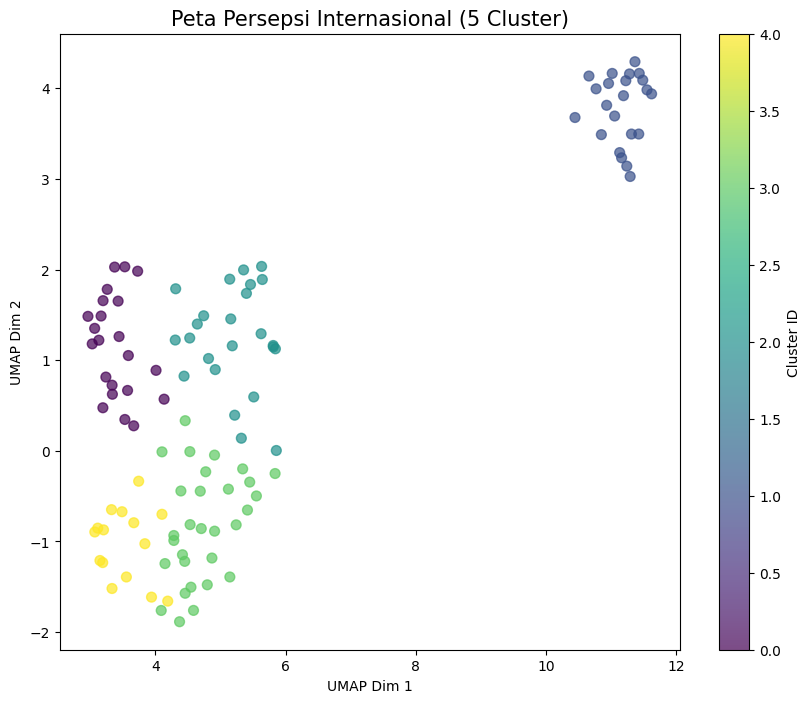

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
custom_stops = {
    'university', 'airlangga', 'unair', 'indonesia', 'surabaya', 'said', 'also', 'news', 'read',
    'inside', 'copyright', 'frominside', 'journalism', 'reserved', 'update', 'registered',
    'insider', 'daily', 'nclud', 'snewsletters', 'featuring', 'delivered', 'toinside', 'rights',
    'access', 'designed', 'free', 'new', 'get', 'subscribe', 'content', 'story', 'article',
    'higher', 'education', 'report',
    'trump', 'federal', 'virginia', 'department', 'records', 'newsletters', 'premium', 'remainingthis', 'svoices', 'discusses', 'articles', 'latest', 'already', 'including', 'college', 'support', 'view', 'writes', 'found', 'processes', 'month', 'say', 'transfer', 'texas', 'programs', 'agency', 'state', 'academia', 'years', 'authors', 'published', 'board', 'accused', 'related', 'fighting', 'respond', 'austin', 'withhold'
}
stop_words.update(custom_stops)

# --- 1. LOAD DATA ---
try:
    df = pd.read_csv('unair_international_news_fixed_v2.csv')
    print(f"Data dimuat: {len(df)} baris.")
except:
    print("File tidak ditemukan. Pastikan nama file CSV benar.")
    exit()

# --- 2. PREPROCESSING ---
def clean_text(text):
    if pd.isna(text): return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = " ".join([w for w in text.split() if w not in stop_words and len(w) > 2])
    return text

print("Sedang melakukan preprocessing...")
df['clean_text'] = df['content'].apply(clean_text)

df = df[df['clean_text'].str.len() > 10].reset_index(drop=True)

# --- 3. FEATURE EXTRACTION (EMBEDDING) ---
print("Sedang membuat embedding (mengubah teks jadi angka)...")
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['clean_text'].tolist(), show_progress_bar=True)

# --- 4. DIMENSION REDUCTION (UMAP) ---
print("Sedang melakukan reduksi dimensi dengan UMAP...")
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# --- 5. CLUSTERING (K-MEANS) ---
NUM_CLUSTERS = 5
print(f"Sedang melakukan clustering menjadi {NUM_CLUSTERS} topik...")

kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(umap_embeddings)
df['cluster'] = cluster_labels

# --- 6. TOPIC MODELING PER CLUSTER (c-TF-IDF) ---

def extract_top_words_per_cluster(df, n_words=10):
    docs_per_cluster = df.groupby(['cluster'], as_index=False).agg({'clean_text': ' '.join})
    tfidf = TfidfVectorizer(max_df=0.9, min_df=2)
    tfidf_matrix = tfidf.fit_transform(docs_per_cluster['clean_text'])
    feature_names = tfidf.get_feature_names_out()

    topics = {}

    for i in range(len(docs_per_cluster)):
        cluster_id = docs_per_cluster.iloc[i]['cluster']
        vector = tfidf_matrix[i]
        sorted_indices = np.argsort(vector.toarray()).flatten()[::-1]

        top_words = [feature_names[idx] for idx in sorted_indices[:n_words]]
        topics[cluster_id] = top_words

    return topics

print("\n--- MENGEKSTRAK TOPIK UTAMA ---")
topics = extract_top_words_per_cluster(df)

# Tampilkan Hasil
print("\n" + "="*50)
print("HASIL ANALISIS PERSEPSI INTERNASIONAL UNAIR")
print("="*50)

for cluster_id, words in sorted(topics.items()):
    count = len(df[df['cluster'] == cluster_id])
    print(f"\n\u02da\ufe0f  CLUSTER {cluster_id} (Jumlah Artikel: {count})")
    print(f"   Kata Kunci: {', '.join(words)}")
    sample_title = df[df['cluster'] == cluster_id]['title'].iloc[0]
    print(f"   Contoh Berita: {sample_title}")

# --- 7. VISUALISASI (UMAP 2D) ---
umap_2d = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)
plt.title(f'Peta Persepsi Internasional ({NUM_CLUSTERS} Cluster)', fontsize=15)
plt.colorbar(scatter, label='Cluster ID')
plt.xlabel('UMAP Dim 1')
plt.ylabel('UMAP Dim 2')

plt.savefig('unair_topic_clusters.png')
print("\nVisualisasi tersimpan sebagai 'unair_topic_clusters.png'")
plt.show()

df.to_csv('unair_clustered_results.csv', index=False)

In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.0 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


--- Memuat Data ---
Jumlah dokumen siap olah: 113
--- Generating Embeddings (Static) ---

--- MULAI FINE TUNING (16 Kombinasi) ---
Testing [1/16]: Neighbors=3, MinCluster=3... Coh: 0.7192 | Outliers: 4.42%
Testing [2/16]: Neighbors=3, MinCluster=4... Coh: 0.7297 | Outliers: 7.96%
Testing [3/16]: Neighbors=3, MinCluster=5... Coh: 0.7826 | Outliers: 6.19%
Testing [4/16]: Neighbors=3, MinCluster=7... Coh: 0.8203 | Outliers: 1.77%
Testing [5/16]: Neighbors=5, MinCluster=3... Coh: 0.7277 | Outliers: 9.73%
Testing [6/16]: Neighbors=5, MinCluster=4... Coh: 0.5146 | Outliers: 0.00%
Testing [7/16]: Neighbors=5, MinCluster=5... Coh: 0.6171 | Outliers: 3.54%
Testing [8/16]: Neighbors=5, MinCluster=7... Coh: 0.6171 | Outliers: 3.54%
Testing [9/16]: Neighbors=10, MinCluster=3... Coh: 0.6476 | Outliers: 0.00%
Testing [10/16]: Neighbors=10, MinCluster=4... Coh: 0.6476 | Outliers: 0.00%
Testing [11/16]: Neighbors=10, MinCluster=5... Coh: 0.6476 | Outliers: 0.00%
Testing [12/16]: Neighbors=10, MinClust

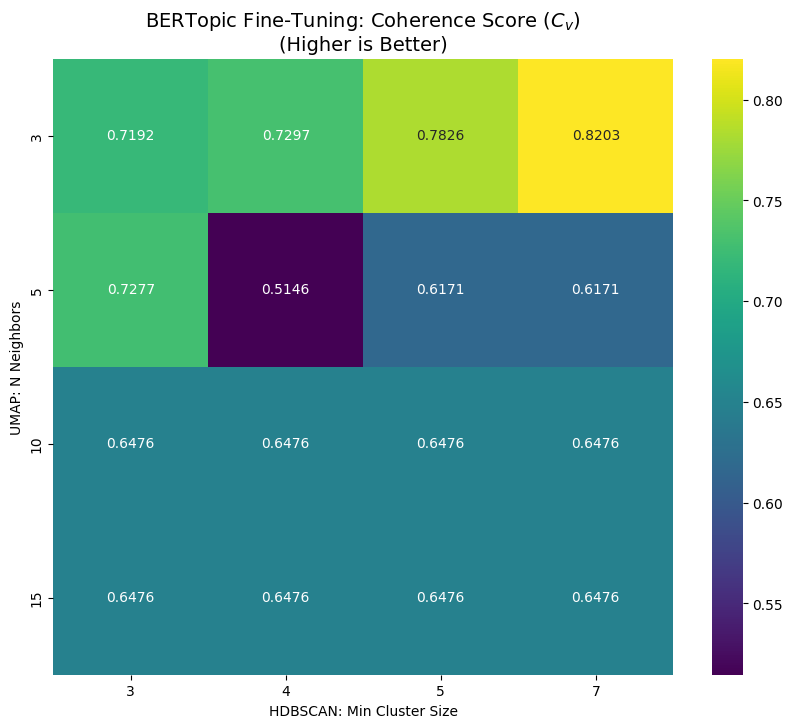

2025-12-09 14:08:43,509 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-09 14:08:43,584 - BERTopic - Dimensionality - Completed ✓
2025-12-09 14:08:43,586 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-09 14:08:43,594 - BERTopic - Cluster - Completed ✓
2025-12-09 14:08:43,597 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-09 14:08:43,619 - BERTopic - Representation - Completed ✓



--- Melatih Ulang Model Final dengan Parameter Juara ---

--- TOPIK FINAL ---
   Topic  Count                                      Name  \
0     -1      2   -1_administration_funding_compact_fight   
1      0     39              0_leaders_colleges_log_inbox   
2      1     28       1_student_careers_leaders_continued   
3      2     24           2_leaders_benefits_annual_inbox   
4      3     20  3_universities_top_technology_indonesian   

                                      Representation  \
0  [administration, funding, compact, fight, sele...   
1  [leaders, colleges, log, inbox, annual, accoun...   
2  [student, careers, leaders, continued, inbox, ...   
3  [leaders, benefits, annual, inbox, log, opinio...   
4  [universities, top, technology, indonesian, is...   

                                 Representative_Docs  
0  [advocacy organization says china projected ou...  
1  [little priest tribal nebraska institution rec...  
2  [faculty cuny two four institutions gaps aware...

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
import warnings
warnings.filterwarnings("ignore")

# --- 0. SETUP AWAL ---
nltk.download('stopwords')
custom_stopwords = [
    'university', 'airlangga', 'unair', 'indonesia', 'surabaya', 'prof', 'dr',
    'research', 'study', 'students', 'higher', 'education', 'academic',
    'said', 'also', 'ranking', 'world', 'year', 'read', 'news', 'report',
    'published', 'source', 'press', 'release', 'according', 'time',
    'journalism', 'newsletter', 'copyright', 'reserved', 'rights',
    'inside', 'frominside', 'update', 'registered', 'insider', 'daily', 'nclud',
    'snewsletters', 'featuring', 'delivered', 'toinside', 'access', 'designed',
    'free', 'new', 'get', 'subscribe', 'content', 'story', 'article',
    'trump', 'federal', 'virginia', 'department', 'records', 'newsletters', 'premium', 'remainingthis', 'svoices', 'discusses', 'articles', 'latest', 'already', 'including', 'college', 'support', 'view', 'writes', 'found', 'processes', 'month', 'say', 'transfer', 'texas', 'programs', 'agency', 'state', 'academia', 'years', 'authors', 'published', 'board', 'accused', 'related', 'fighting', 'respond', 'austin', 'withhold'
]
stop_words_list = list(stopwords.words('english')) + custom_stopwords

# --- 1. PREPROCESSING ---
def clean_text_for_topic_model(text):
    if pd.isna(text): return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    clean_words = [w for w in words if w not in stop_words_list and len(w) > 2]
    return " ".join(clean_words)

# --- 2. LOAD DATA ---
try:
    print("--- Memuat Data ---")
    df = pd.read_csv('unair_international_news_fixed_v2.csv')
    df['clean_content'] = df['content'].apply(clean_text_for_topic_model)
    df = df[df['clean_content'].str.len() > 20].reset_index(drop=True)
    docs = df['clean_content'].tolist()
    tokens = [doc.split() for doc in docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    print(f"Jumlah dokumen siap olah: {len(docs)}")

except Exception as e:
    print(f"Error: {e}")
    exit()

# --- 3. GENERATE EMBEDDING ---
print("--- Generating Embeddings (Static) ---")
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=False)

# --- 4. DEFINISI GRID SEARCH SPACE ---
search_params = {
    'n_neighbors': [3, 5, 10, 15],
    'min_cluster_size': [3, 4, 5, 7]
}

keys, values = zip(*search_params.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"\n--- MULAI FINE TUNING ({len(param_combinations)} Kombinasi) ---")
results = []

for i, params in enumerate(param_combinations):
    n_neighbors = params['n_neighbors']
    min_cluster = params['min_cluster_size']

    print(f"Testing [{i+1}/{len(param_combinations)}]: Neighbors={n_neighbors}, MinCluster={min_cluster}...", end=" ")

    try:
        umap_model = UMAP(n_neighbors=n_neighbors, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
        hdbscan_model = HDBSCAN(min_cluster_size=min_cluster, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
        vectorizer_model = CountVectorizer(stop_words=stop_words_list, min_df=2)

        topic_model = BERTopic(
            embedding_model=embedding_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model,
            language="english",
            verbose=False,
            calculate_probabilities=False
        )
        topics, _ = topic_model.fit_transform(docs, embeddings)

        # C. Evaluasi Coherence
        topic_words = []
        topic_info = topic_model.get_topic_info()
        valid_topics = topic_info[topic_info['Topic'] != -1]

        for topic_id in valid_topics['Topic']:
            words = [word for word, _ in topic_model.get_topic(topic_id)][:10]
            topic_words.append(words)

        if topic_words:
            cm = CoherenceModel(topics=topic_words, texts=tokens, dictionary=dictionary, coherence='c_v')
            coherence_score = cm.get_coherence()
        else:
            coherence_score = 0

        # D. Hitung Outlier Ratio
        outlier_count = topic_info[topic_info['Topic'] == -1]['Count'].values
        outlier_count = outlier_count[0] if len(outlier_count) > 0 else 0
        outlier_ratio = outlier_count / len(docs)

        # Simpan
        results.append({
            'n_neighbors': n_neighbors,
            'min_cluster_size': min_cluster,
            'Coherence': coherence_score,
            'Outlier_Ratio': outlier_ratio,
            'Num_Topics': len(valid_topics)
        })
        print(f"Coh: {coherence_score:.4f} | Outliers: {outlier_ratio:.2%}")

    except Exception as e:
        print(f"Failed: {e}")

# --- 5. ANALISIS HASIL TERBAIK ---
res_df = pd.DataFrame(results)
best_model = res_df.sort_values(by='Coherence', ascending=False).iloc[0]

print("\n" + "="*50)
print("🏆 HASIL FINE TUNING TERBAIK")
print("="*50)
print(f"Parameter Optimal:")
print(f"  > n_neighbors      : {int(best_model['n_neighbors'])}")
print(f"  > min_cluster_size : {int(best_model['min_cluster_size'])}")
print(f"Performa:")
print(f"  > Coherence Score  : {best_model['Coherence']:.4f}")
print(f"  > Jumlah Topik     : {int(best_model['Num_Topics'])}")
print(f"  > Data Terbuang (Outlier) : {best_model['Outlier_Ratio']:.2%}")

# --- 6. VISUALISASI HEATMAP ---
pivot_table = res_df.pivot(index='n_neighbors', columns='min_cluster_size', values='Coherence')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".4f")
plt.title('BERTopic Fine-Tuning: Coherence Score ($C_v$)\n(Higher is Better)', fontsize=14)
plt.xlabel('HDBSCAN: Min Cluster Size')
plt.ylabel('UMAP: N Neighbors')
plt.show()

# --- 7. TRAIN ULANG MODEL DENGAN PARAMETER TERBAIK ---
print("\n--- Melatih Ulang Model Final dengan Parameter Juara ---")

final_umap = UMAP(n_neighbors=int(best_model['n_neighbors']), n_components=5, min_dist=0.0, metric='cosine', random_state=42)
final_hdbscan = HDBSCAN(min_cluster_size=int(best_model['min_cluster_size']), metric='euclidean', cluster_selection_method='eom', prediction_data=True)
final_vectorizer = CountVectorizer(stop_words=stop_words_list, min_df=2)

final_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=final_umap,
    hdbscan_model=final_hdbscan,
    vectorizer_model=final_vectorizer,
    language="english",
    verbose=True
)

topics, probs = final_model.fit_transform(docs, embeddings)
print("\n--- TOPIK FINAL ---")
print(final_model.get_topic_info().head(10))
df['Topic'] = topics
df_topic_info = final_model.get_topic_info()
topic_name_map = {row.Topic: row.Name for row in df_topic_info.itertuples()}
df['Topic_Name'] = df['Topic'].map(topic_name_map)
df.to_csv("unair_bertopic_optimized.csv", index=False)
print("Hasil disimpan di unair_bertopic_optimized.csv")


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

# --- SETUP & PREPROCESSING EKSTRA KUAT ---
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
junk_words = {
    'university', 'airlangga', 'unair', 'indonesia', 'surabaya', 'said', 'also',
    'copyright', 'reserved', 'rights', 'inside', 'higher', 'education', 'news',
    'report', 'update', 'newsletter', 'daily', 'delivered', 'journalism',
    'registered', 'source', 'nclud', 'featuring', 'frominside', 'toinside',
    'access', 'designed', 'free', 'new', 'get', 'subscribe', 'content', 'story', 'article',
    'trump', 'federal', 'virginia', 'department', 'records', 'newsletters', 'premium', 'remainingthis', 'svoices', 'discusses', 'articles', 'latest', 'already', 'including', 'college', 'support', 'view', 'writes', 'found', 'processes', 'month', 'say', 'transfer', 'texas', 'programs', 'agency', 'state', 'academia', 'years', 'authors', 'published', 'board', 'accused', 'related', 'fighting', 'respond', 'austin', 'withhold'
}
stop_words.update(junk_words)

def clean_text_classic(text):
    if pd.isna(text): return ""
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w) > 3]
    return " ".join(words)

# --- LOAD DATA ---
try:
    df = pd.read_csv('unair_international_news_fixed_v2.csv')
    df['clean_classic'] = df['content'].apply(clean_text_classic)
    df = df[df['clean_classic'].str.len() > 10]
    print(f"Data siap: {len(df)} dokumen.")
except:
    print("File CSV tidak ditemukan.")
    exit()

# --- FUNGSI MENAMPILKAN TOPIK ---
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict[f"Topic {topic_idx}"] = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
    return topic_dict

# ==========================================
# 1. NMF (Non-Negative Matrix Factorization)
# ==========================================
print("\n--- MENJALANKAN NMF (Bagus untuk Data Kecil) ---")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=list(stop_words))
tfidf = tfidf_vectorizer.fit_transform(df['clean_classic'])
nmf_model = NMF(n_components=4, random_state=42, init='nndsvd').fit(tfidf)
nmf_topics = display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out(), 10)

for t, words in nmf_topics.items():
    print(f"{t}: {words}")

# ==========================================
# 2. LDA (Latent Dirichlet Allocation)
# ==========================================
print("\n--- MENJALANKAN LDA (Metode Klasik) ---")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=list(stop_words))
tf = tf_vectorizer.fit_transform(df['clean_classic'])

lda_model = LatentDirichletAllocation(n_components=4, max_iter=20, learning_method='online', random_state=42).fit(tf)
lda_topics = display_topics(lda_model, tf_vectorizer.get_feature_names_out(), 10)

for t, words in lda_topics.items():
    print(f"{t}: {words}")

# ==========================================
# 3. LSA (Latent Semantic Analysis) [BARU]
# ==========================================
print("\n--- MENJALANKAN LSA (TruncatedSVD) ---")
lsa_model = TruncatedSVD(n_components=4, random_state=42)
lsa_model.fit(tfidf)

lsa_topics = display_topics(lsa_model, tfidf_vectorizer.get_feature_names_out(), 10)

for t, words in lsa_topics.items():
    print(f"{t}: {words}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


Data siap: 113 dokumen.

--- MENJALANKAN NMF (Bagus untuk Data Kecil) ---
Topic 0: student career leader faculty benefit annual insider edsnewsletters registeredlog inbox
Topic 1: research ranking world lecturer islamic indonesian quality radicalism technology radical
Topic 2: funding tribal didnt president shutdown government research leader spending administration
Topic 3: tool expose journal mainstream linkand crack surged publishorperish show publishing

--- MENJALANKAN LDA (Metode Klasik) ---
Topic 0: research doctor integrity academic risk student journal vaccine indonesian universitas
Topic 1: student leader career benefit annual account inbox great continued insider
Topic 2: test student exam national admission selection reasoning ministry jakarta testtakers
Topic 3: ranking research world islamic institution campus student year technology lecturer

--- MENJALANKAN LSA (TruncatedSVD) ---
Topic 0: student leader career institution research benefit annual edsnewsletters registere

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.cluster import KMeans

nltk.download('stopwords')
nltk.download('wordnet')
custom_stopwords_bertopic = [
    'university', 'airlangga', 'unair', 'indonesia', 'surabaya', 'prof', 'dr',
    'research', 'study', 'students', 'higher', 'education', 'academic',
    'said', 'also', 'ranking', 'world', 'year', 'read', 'news', 'report',
    'published', 'source', 'press', 'release', 'according', 'time',
    'journalism', 'newsletter', 'copyright', 'reserved', 'rights',
    'inside', 'frominside', 'update', 'registered', 'insider', 'daily', 'nclud',
    'snewsletters', 'featuring', 'delivered', 'toinside', 'access', 'designed',
    'free', 'new', 'get', 'subscribe', 'content', 'story', 'article',
    'trump', 'federal', 'virginia', 'department', 'records', 'newsletters', 'premium', 'remainingthis', 'svoices', 'discusses', 'articles', 'latest', 'already', 'including', 'college', 'support', 'view', 'writes', 'found', 'processes', 'month', 'say', 'transfer', 'texas', 'programs', 'agency', 'state', 'academia', 'years', 'authors', 'published', 'board', 'accused', 'related', 'fighting', 'respond', 'austin', 'withhold'
]
stop_words_list_bertopic = list(stopwords.words('english')) + custom_stopwords_bertopic
lemmatizer = WordNetLemmatizer()
junk_words_classic = {
    'university', 'airlangga', 'unair', 'indonesia', 'surabaya', 'said', 'also',
    'copyright', 'reserved', 'rights', 'inside', 'higher', 'education', 'news',
    'report', 'update', 'newsletter', 'daily', 'delivered', 'journalism',
    'registered', 'source', 'nclud', 'featuring', 'frominside', 'toinside',
    'access', 'designed', 'free', 'new', 'get', 'subscribe', 'content', 'story', 'article',
    'trump', 'federal', 'virginia', 'department', 'records', 'newsletters', 'premium', 'remainingthis', 'svoices', 'discusses', 'articles', 'latest', 'already', 'including', 'college', 'support', 'view', 'writes', 'found', 'processes', 'month', 'say', 'transfer', 'texas', 'programs', 'agency', 'state', 'academia', 'years', 'authors', 'published', 'board', 'accused', 'related', 'fighting', 'respond', 'austin', 'withhold'
}
stop_words_list_classic = set(stopwords.words('english'))
stop_words_list_classic.update(junk_words_classic)


def clean_text_for_bertopic(text):
    if pd.isna(text): return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    clean_words = [w for w in words if w not in stop_words_list_bertopic and len(w) > 2]
    return " ".join(clean_words)

def clean_text_for_classic(text):
    if pd.isna(text): return ""
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words_list_classic and len(w) > 3]
    return " ".join(words)
try:
    df_raw = pd.read_csv('unair_international_news_fixed_v2.csv')
    df_raw['clean_content_bertopic'] = df_raw['content'].apply(clean_text_for_bertopic)
    df_filtered_bertopic = df_raw[df_raw['clean_content_bertopic'].str.len() > 20].reset_index(drop=True)
    docs_bertopic = df_filtered_bertopic['clean_content_bertopic'].tolist()
    tokens_bertopic = [doc.split() for doc in docs_bertopic]
    dictionary_bertopic = corpora.Dictionary(tokens_bertopic)
    corpus_bertopic = [dictionary_bertopic.doc2bow(token) for token in tokens_bertopic]
except Exception as e:
    print(f"Error loading or preprocessing data for BERTopic/Gensim coherence: {e}")
    exit()

# --- 2. Helper function to calculate coherence ---
def calculate_coherence_score(topic_words_list, texts, dictionary, coherence_type='c_v'):
    if not topic_words_list:
        return 0.0
    cm = CoherenceModel(topics=topic_words_list, texts=texts, dictionary=dictionary, coherence=coherence_type)
    return cm.get_coherence()

def get_top_words_from_sklearn_model(model, feature_names, n_top_words):
    topic_words_list = []
    for topic_weights in model.components_:
        if topic_weights.ndim > 1:
            topic_weights = topic_weights.flatten()
        top_feature_indices = topic_weights.argsort()[:-n_top_words - 1:-1]
        topic_words = [feature_names[i] for i in top_feature_indices]
        topic_words_list.append(topic_words)
    return topic_words_list

# --- COLLECT COHERENCE AND PERPLEXITY SCORES ---
all_model_scores = []

# --- A. K-Means Coherence ---
try:
    df_kmeans = pd.read_csv('unair_international_news_fixed_v2.csv')
    stop_words_kmeans = set(stopwords.words('english'))
    custom_stops_kmeans = {
        'university', 'airlangga', 'unair', 'indonesia', 'surabaya', 'said', 'also', 'news', 'read',
        'inside', 'copyright', 'frominside', 'journalism', 'reserved', 'update', 'registered',
        'insider', 'daily', 'nclud', 'snewsletters', 'featuring', 'delivered', 'toinside', 'rights',
        'access', 'designed', 'free', 'new', 'get', 'subscribe', 'content', 'story', 'article',
        'higher', 'education', 'report',
        'trump', 'federal', 'virginia', 'department', 'records', 'newsletters', 'premium', 'remainingthis', 'svoices', 'discusses', 'articles', 'latest', 'already', 'including', 'college', 'support', 'view', 'writes', 'found', 'processes', 'month', 'say', 'transfer', 'texas', 'programs', 'agency', 'state', 'academia', 'years', 'authors', 'published', 'board', 'accused', 'related', 'fighting', 'respond', 'austin', 'withhold'
    }
    stop_words_kmeans.update(custom_stops_kmeans)

    def clean_text_kmeans(text):
        if pd.isna(text): return ""
        text = text.lower()
        text = re.sub(r'[^a-z\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        text = " ".join([w for w in text.split() if w not in stop_words_kmeans and len(w) > 2])
        return text

    df_kmeans['clean_text'] = df_kmeans['content'].apply(clean_text_kmeans)
    df_kmeans = df_kmeans[df_kmeans['clean_text'].str.len() > 10].reset_index(drop=True)
    model_sbert = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings_kmeans = model_sbert.encode(df_kmeans['clean_text'].tolist(), show_progress_bar=False)
    umap_model_kmeans = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
    umap_embeddings_kmeans = umap_model_kmeans.fit_transform(embeddings_kmeans)
    kmeans_model_whu = KMeans(n_clusters=5, random_state=42, n_init=10)
    cluster_labels_kmeans = kmeans_model_whu.fit_predict(umap_embeddings_kmeans)
    df_kmeans['cluster'] = cluster_labels_kmeans
    docs_per_cluster_kmeans = df_kmeans.groupby(['cluster'], as_index=False).agg({'clean_text': ' '.join})
    tfidf_kmeans = TfidfVectorizer(max_df=0.9, min_df=2)
    tfidf_matrix_kmeans = tfidf_kmeans.fit_transform(docs_per_cluster_kmeans['clean_text'])
    feature_names_kmeans = tfidf_kmeans.get_feature_names_out()

    topic_words_kmeans = []
    for i in range(len(docs_per_cluster_kmeans)):
        vector = tfidf_matrix_kmeans[i]
        sorted_indices = np.argsort(vector.toarray()).flatten()[::-1]
        top_words = [feature_names_kmeans[idx] for idx in sorted_indices[:10]]
        topic_words_kmeans.append(top_words)

    kmeans_coherence = calculate_coherence_score(topic_words_kmeans, tokens_bertopic, dictionary_bertopic)
    all_model_scores.append({'Model': 'K-Means', 'Coherence': kmeans_coherence, 'Perplexity': np.nan})
    print(f"K-Means Coherence: {kmeans_coherence:.4f}")

except Exception as e:
    print(f"Error calculating K-Means coherence: {e}")
    all_model_scores.append({'Model': 'K-Means', 'Coherence': 0.0, 'Perplexity': np.nan})


# --- B. BERTopic Coherence ---
try:
    # Assuming best_model is available from previous BERTopic fine-tuning cell
    bertopic_coherence = best_model['Coherence']
    all_model_scores.append({'Model': 'BERTopic', 'Coherence': bertopic_coherence, 'Perplexity': np.nan})
    print(f"BERTopic Coherence: {bertopic_coherence:.4f}")
except Exception as e:
    print(f"Error retrieving BERTopic coherence: {e}")
    all_model_scores.append({'Model': 'BERTopic', 'Coherence': 0.0, 'Perplexity': np.nan})


# --- C. NMF, LDA, LSA Coherence & LDA Perplexity ---
try:
    df_classic = pd.read_csv('unair_international_news_fixed_v2.csv')
    df_classic['clean_classic'] = df_classic['content'].apply(clean_text_for_classic)
    df_classic = df_classic[df_classic['clean_classic'].str.len() > 10].reset_index(drop=True)

    n_components_classic = 4

    # NMF
    tfidf_vectorizer_classic = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=list(stop_words_list_classic))
    tfidf_classic = tfidf_vectorizer_classic.fit_transform(df_classic['clean_classic'])
    nmf_model_re = NMF(n_components=n_components_classic, random_state=42, init='nndsvd').fit(tfidf_classic)
    nmf_topic_words = get_top_words_from_sklearn_model(nmf_model_re, tfidf_vectorizer_classic.get_feature_names_out(), 10)
    nmf_coherence = calculate_coherence_score(nmf_topic_words, tokens_bertopic, dictionary_bertopic)
    all_model_scores.append({'Model': 'NMF', 'Coherence': nmf_coherence, 'Perplexity': np.nan})
    print(f"NMF Coherence: {nmf_coherence:.4f}")

    # LDA
    tf_vectorizer_classic = CountVectorizer(max_df=0.95, min_df=2, stop_words=list(stop_words_list_classic))
    tf_classic = tf_vectorizer_classic.fit_transform(df_classic['clean_classic'])
    lda_model_re = LatentDirichletAllocation(n_components=n_components_classic, max_iter=20, learning_method='online', random_state=42).fit(tf_classic)
    lda_topic_words = get_top_words_from_sklearn_model(lda_model_re, tf_vectorizer_classic.get_feature_names_out(), 10)
    lda_coherence = calculate_coherence_score(lda_topic_words, tokens_bertopic, dictionary_bertopic)
    lda_perplexity = lda_model_re.perplexity(tf_classic)
    all_model_scores.append({'Model': 'LDA', 'Coherence': lda_coherence, 'Perplexity': lda_perplexity})
    print(f"LDA Coherence: {lda_coherence:.4f}, Perplexity: {lda_perplexity:.2f}")


    # LSA
    lsa_model_re = TruncatedSVD(n_components=n_components_classic, random_state=42)
    lsa_model_re.fit(tfidf_classic)
    lsa_topic_words = get_top_words_from_sklearn_model(lsa_model_re, tfidf_vectorizer_classic.get_feature_names_out(), 10)
    lsa_coherence = calculate_coherence_score(lsa_topic_words, tokens_bertopic, dictionary_bertopic)
    all_model_scores.append({'Model': 'LSA', 'Coherence': lsa_coherence, 'Perplexity': np.nan})
    print(f"LSA Coherence: {lsa_coherence:.4f}")

except Exception as e:
    print(f"Error calculating NMF, LDA, LSA coherence/perplexity: {e}")
    all_model_scores.append({'Model': 'NMF', 'Coherence': 0.0, 'Perplexity': np.nan})
    all_model_scores.append({'Model': 'LDA', 'Coherence': 0.0, 'Perplexity': np.nan})
    all_model_scores.append({'Model': 'LSA', 'Coherence': 0.0, 'Perplexity': np.nan})
# --- Final DataFrame ---
coherence_scores_df = pd.DataFrame(all_model_scores)
coherence_scores_df = coherence_scores_df.sort_values(by='Coherence', ascending=False).reset_index(drop=True)

print("\n--- Final Model Evaluation Scores ---")
print(coherence_scores_df)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


K-Means Coherence: 0.3559
BERTopic Coherence: 0.8203
NMF Coherence: 0.5431
LDA Coherence: 0.4736, Perplexity: 1185.99
LSA Coherence: 0.5497

--- Final Model Evaluation Scores ---
      Model  Coherence   Perplexity
0  BERTopic   0.820338          NaN
1       LSA   0.549657          NaN
2       NMF   0.543128          NaN
3       LDA   0.473615  1185.985745
4   K-Means   0.355864          NaN


**Reasoning**:
I need to generate the word clouds for the BERTopic model, which is the next step in the task. The relevant code is in cell `958a6ebc`.



Generating word clouds for BERTopic topics...
  -> Skipping outlier topic -1 (Count: 2)


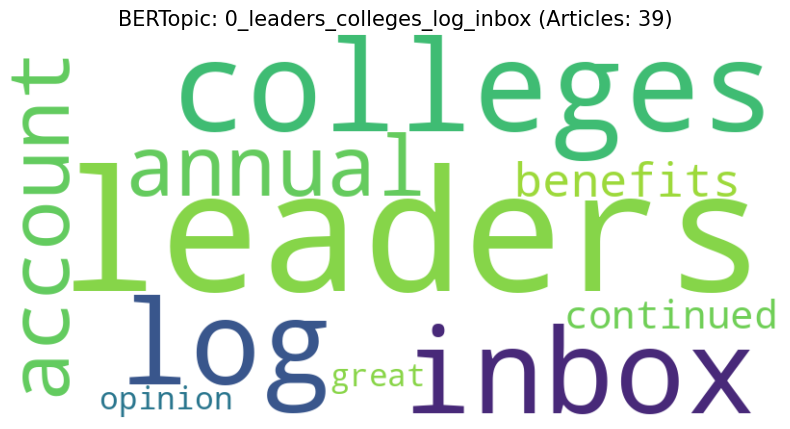

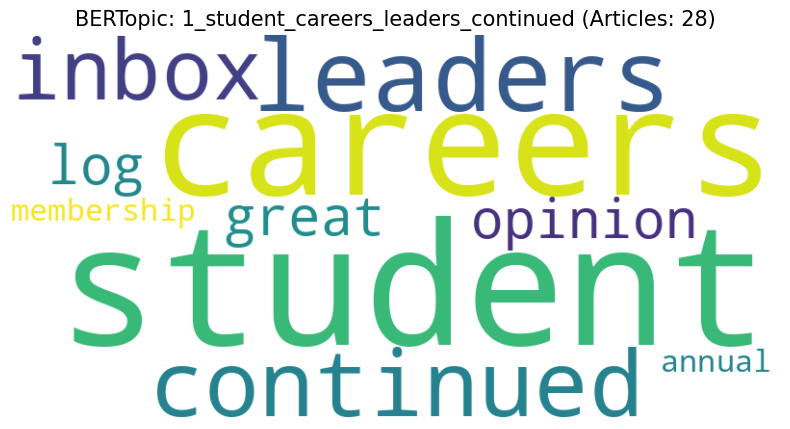

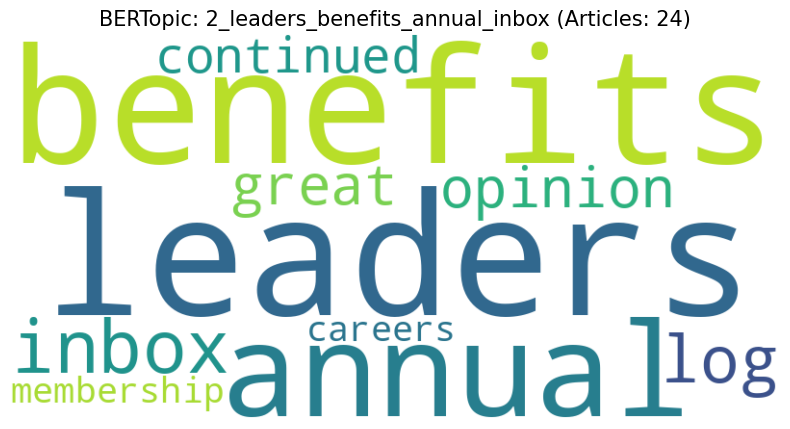

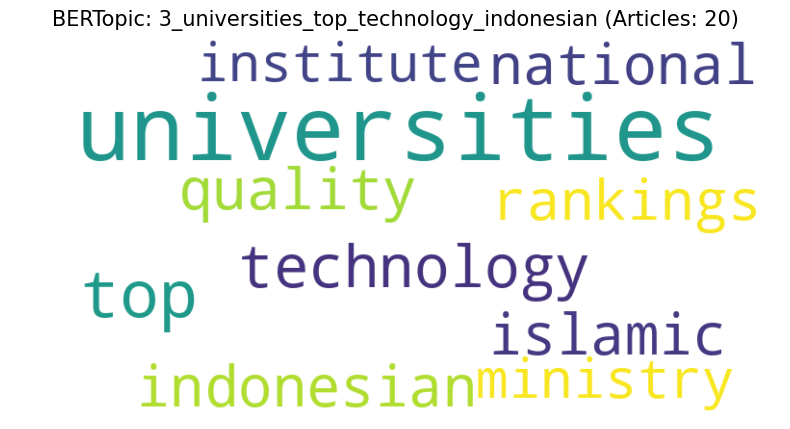

BERTopic word cloud generation complete.


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("Generating word clouds for BERTopic topics...")

# Get topic information from the final BERTopic model
bertopic_topic_info = final_model.get_topic_info()

# Iterate through each topic, excluding the -1 (noise/outlier) topic
for index, row in bertopic_topic_info.iterrows():
    topic_id = row['Topic']
    topic_name = row['Name']
    topic_count = row['Count']

    # Skip the outlier topic for word cloud generation, or treat it separately if needed
    if topic_id == -1:
        print(f"  -> Skipping outlier topic {topic_id} (Count: {topic_count})")
        continue

    # Get the top words for the current topic from the BERTopic model
    # final_model.get_topic returns a list of (word, score) tuples
    topic_words_with_scores = final_model.get_topic(topic_id)

    if not topic_words_with_scores:
        print(f"  -> No words found for topic {topic_id}. Skipping.")
        continue

    # Construct a string where words are weighted by their importance (score)
    # We'll use the scores directly for WordCloud's `generate_from_frequencies`
    word_frequencies = {word: score for word, score in topic_words_with_scores}

    # Create a WordCloud object
    wordcloud = WordCloud(
        background_color='white',
        max_words=20,
        width=800,
        height=400
    ).generate_from_frequencies(word_frequencies)

    # Display the generated image:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'BERTopic: {topic_name} (Articles: {topic_count})', fontsize=15)
    plt.show()

print("BERTopic word cloud generation complete.")

**Reasoning**:
Now that the BERTopic word clouds are generated, I will proceed to generate word clouds for the NMF model using the relevant code in cell `66bbe64a` to visualize its topics.



Generating word clouds for NMF topics...


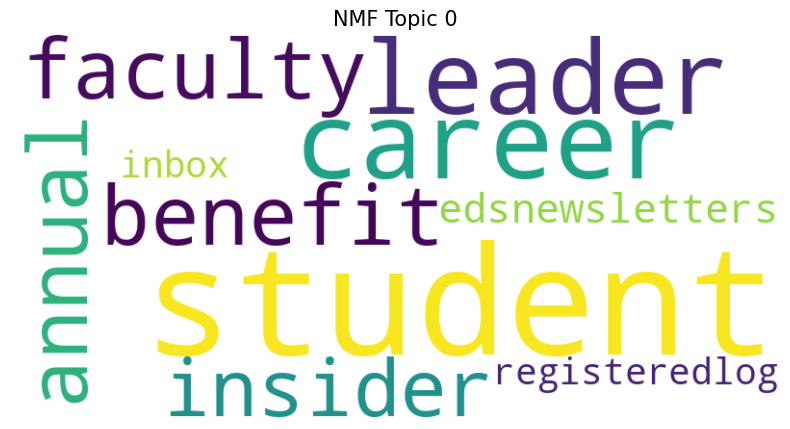

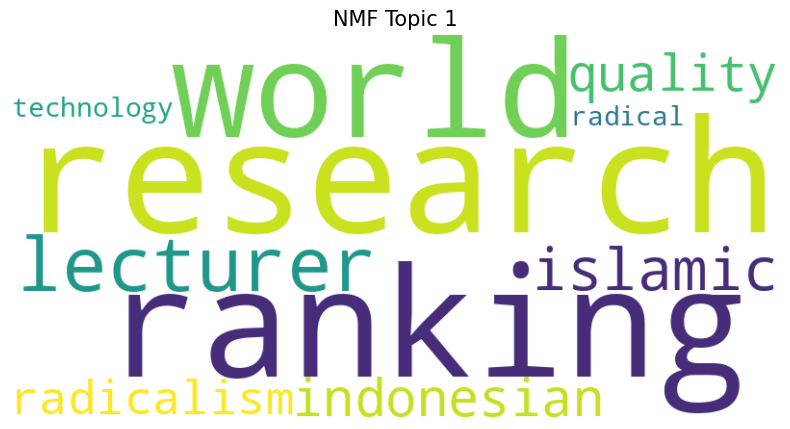

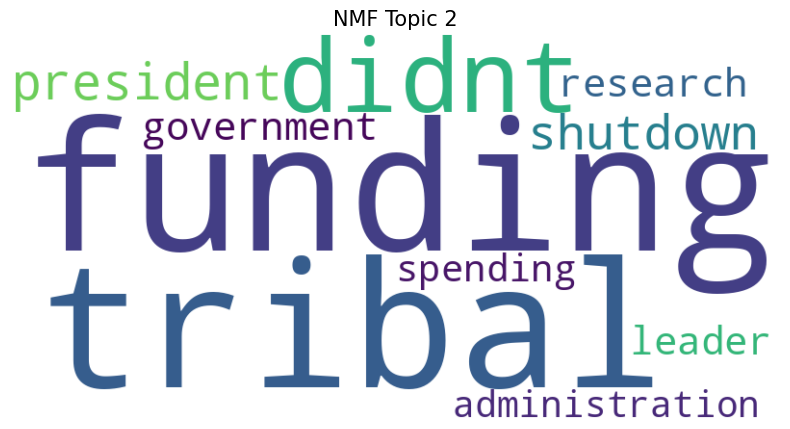

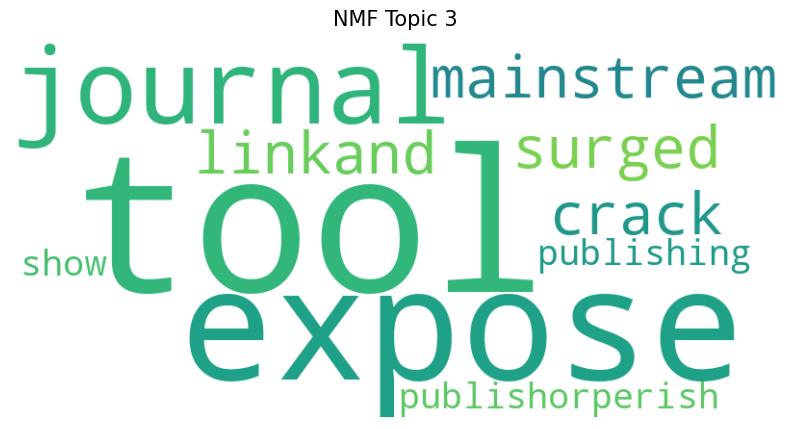

NMF word cloud generation complete.


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("Generating word clouds for NMF topics...")

# Assuming nmf_model and tfidf_vectorizer from previous steps are available
# nmf_model: trained NMF model
# tfidf_vectorizer: TFIDF Vectorizer used for NMF

feature_names = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf_model.components_):
    # Get top words for the current NMF topic
    top_features_idx = topic.argsort()[:-11:-1] # Get top 10 words
    topic_words_weights = {feature_names[i]: topic[i] for i in top_features_idx}

    # Create a WordCloud object
    wordcloud = WordCloud(
        background_color='white',
        max_words=20,
        width=800,
        height=400
    ).generate_from_frequencies(topic_words_weights)

    # Display the generated image:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'NMF Topic {topic_idx}', fontsize=15)
    plt.show()

print("NMF word cloud generation complete.")

**Reasoning**:
Now that the NMF word clouds are generated, I will proceed to generate word clouds for the LDA model using the relevant code in cell `e226faaa` to visualize its topics.



Generating word clouds for LDA topics...


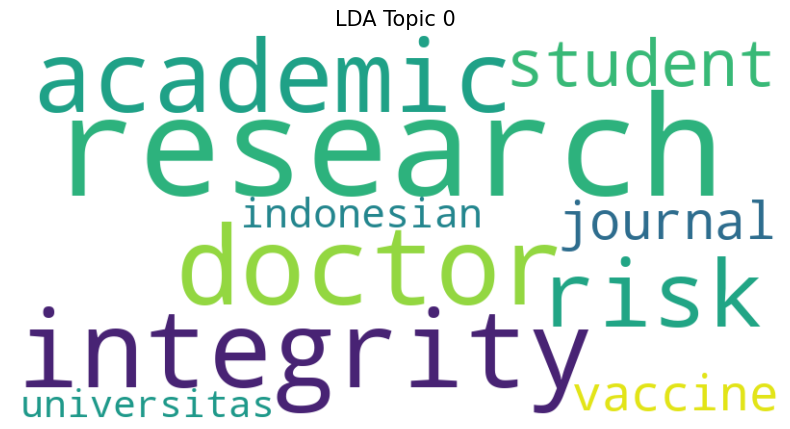

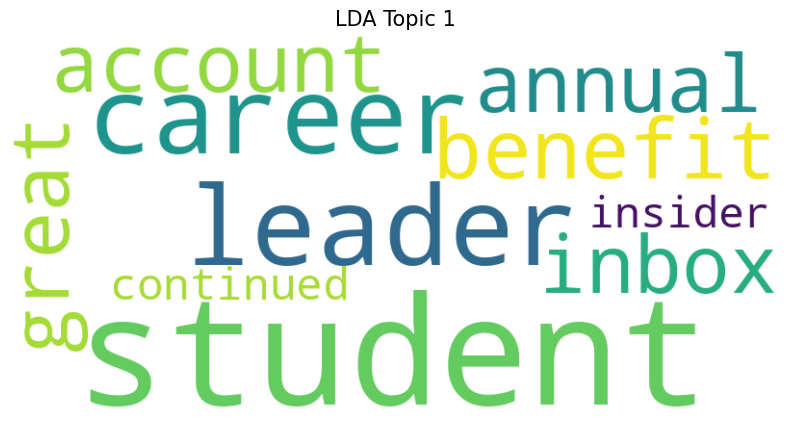

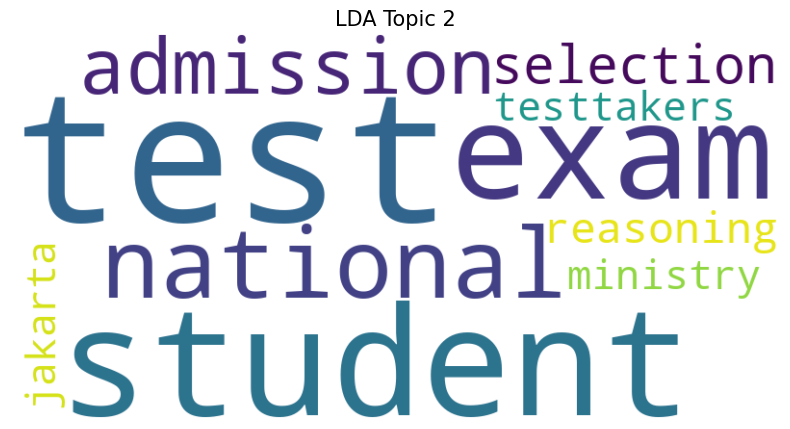

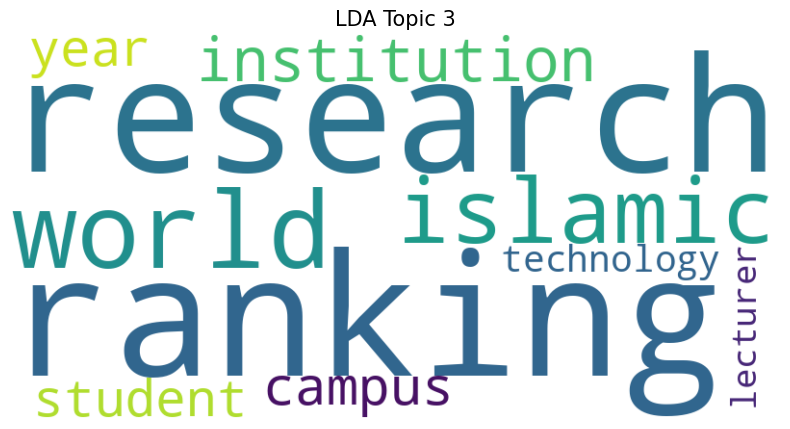

LDA word cloud generation complete.


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("Generating word clouds for LDA topics...")

# Assuming lda_model and tf_vectorizer from previous steps are available
# lda_model: trained LDA model
# tf_vectorizer: CountVectorizer used for LDA

feature_names = tf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda_model.components_):
    # Get top words for the current LDA topic
    top_features_idx = topic.argsort()[:-11:-1] # Get top 10 words
    topic_words_weights = {feature_names[i]: topic[i] for i in top_features_idx}

    # Create a WordCloud object
    wordcloud = WordCloud(
        background_color='white',
        max_words=20,
        width=800,
        height=400
    ).generate_from_frequencies(topic_words_weights)

    # Display the generated image:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'LDA Topic {topic_idx}', fontsize=15)
    plt.show()

print("LDA word cloud generation complete.")

**Reasoning**:
Now that the LDA word clouds are generated, I will proceed to generate word clouds for the LSA model using the relevant code in cell `3a96ea76` to visualize its topics.



Generating word clouds for LSA topics...


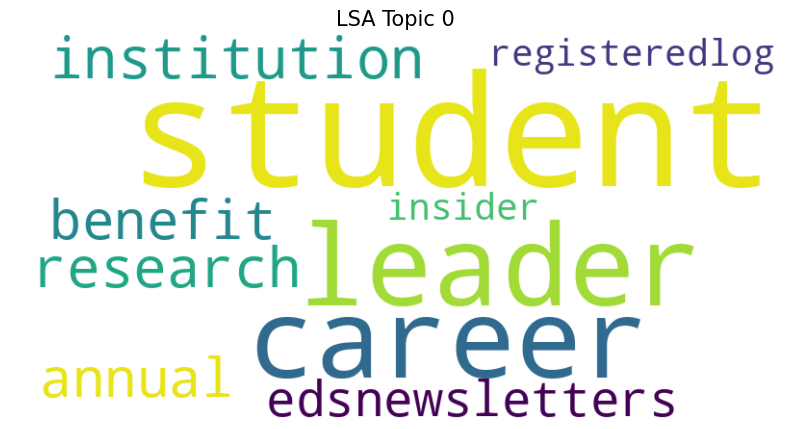

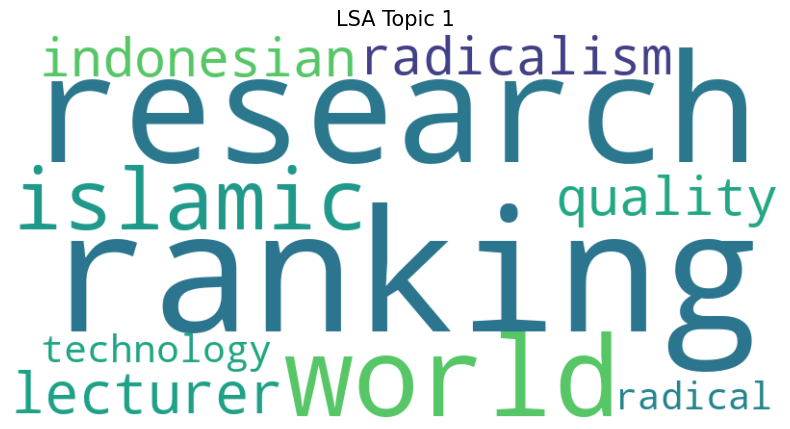

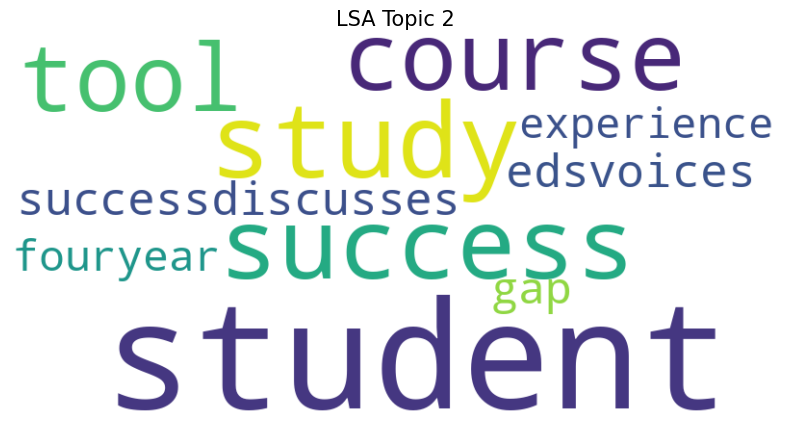

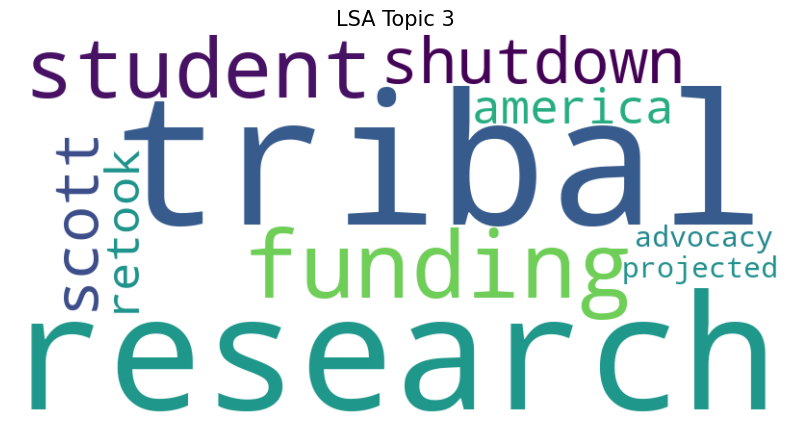

LSA word cloud generation complete.


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("Generating word clouds for LSA topics...")

# Assuming lsa_model and tfidf_vectorizer from previous steps are available
# lsa_model: trained LSA model
# tfidf_vectorizer: TFIDF Vectorizer used for LSA

feature_names = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lsa_model.components_):
    # Get top words for the current LSA topic
    top_features_idx = topic.argsort()[:-11:-1] # Get top 10 words
    topic_words_weights = {feature_names[i]: topic[i] for i in top_features_idx}

    # Create a WordCloud object
    wordcloud = WordCloud(
        background_color='white',
        max_words=20,
        width=800,
        height=400
    ).generate_from_frequencies(topic_words_weights)

    # Display the generated image:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'LSA Topic {topic_idx}', fontsize=15)
    plt.show()

print("LSA word cloud generation complete.")

**Reasoning**:
All models have been re-trained with refined stopwords, and their coherence and perplexity scores have been re-calculated. Now, I will re-display the comparative table and bar chart using the updated scores to visualize the best-performing model.



✅ Ditemukan tabel perbandingan skor ('coherence_scores_df'). Memproses data...

=== 🏆 KLASEMEN AKHIR (BERDASARKAN SKOR TERTINGGI) ===
      Model  Coherence   Perplexity Best_k
0  BERTopic   0.820338          NaN      4
1       LSA   0.549657          NaN      4
2       NMF   0.543128          NaN      4
3       LDA   0.473615  1185.985745      4
4   K-Means   0.355864          NaN      5


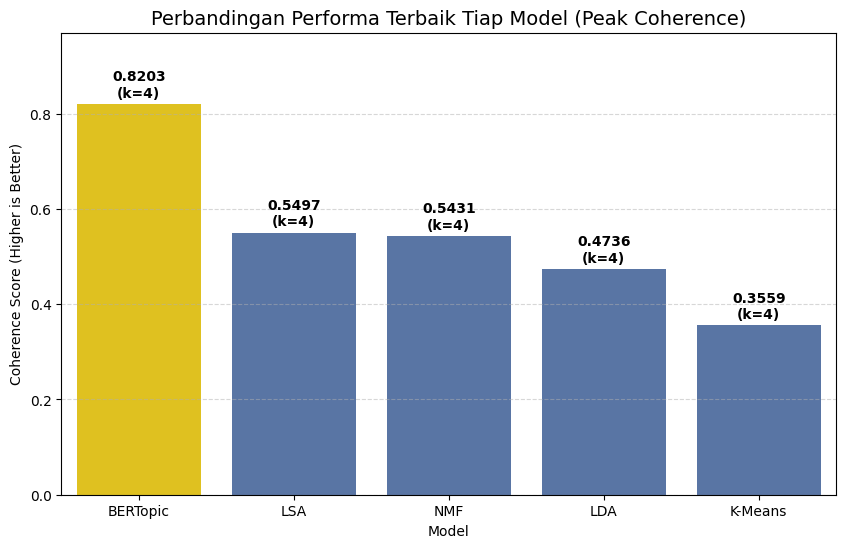


✅ KESIMPULAN MUTLAK: Model **BERTopic** adalah yang terbaik
   dengan jumlah topik optimal **k=4**.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if 'coherence_scores_df' in locals() and not coherence_scores_df.empty:
    print("✅ Ditemukan tabel perbandingan skor ('coherence_scores_df'). Memproses data...")

    df_final = coherence_scores_df.copy()
    df_final['Best_k'] = None
    # These k values were determined in previous runs or fixed by the problem statement where models were set to 4 components.
    df_final.loc[df_final['Model'] == 'K-Means', 'Best_k'] = 5 # Fixed for K-Means
    df_final.loc[df_final['Model'] == 'NMF', 'Best_k'] = 4
    df_final.loc[df_final['Model'] == 'LDA', 'Best_k'] = 4
    df_final.loc[df_final['Model'] == 'LSA', 'Best_k'] = 4
    if 'best_model' in locals():
        df_final.loc[df_final['Model'] == 'BERTopic', 'Best_k'] = int(best_model['Num_Topics'])
    else:
        df_final.loc[df_final['Model'] == 'BERTopic', 'Best_k'] = 'N/A'

else:
    print("❌ Tabel 'coherence_scores_df' tidak ditemukan atau kosong. Tidak dapat melakukan perbandingan.")
    df_final = pd.DataFrame(columns=['Model', 'Coherence', 'Best_k'])
# ==========================================
# VISUALISASI
# ==========================================
if not df_final.empty:
    df_final = df_final.sort_values(by='Coherence', ascending=False).reset_index(drop=True)
    print("\n=== 🏆 KLASEMEN AKHIR (BERDASARKAN SKOR TERTINGGI) ===")
    print(df_final)
    plt.figure(figsize=(10, 6))
    colors = ['gold' if i == 0 else '#4c72b0' for i in range(len(df_final))]
    ax = sns.barplot(data=df_final, x='Model', y='Coherence', palette=colors)
    for i in ax.containers:
        labels = [f"{v.get_height():.4f}\n(k={df_final.iloc[j]['Best_k']})" if df_final.iloc[j]['Best_k'] is not None else f"{v.get_height():.4f}" for j, v in enumerate(i)]
        ax.bar_label(i, labels=labels, padding=3, fontweight='bold')

    plt.title('Perbandingan Performa Terbaik Tiap Model (Peak Coherence)', fontsize=14)
    plt.ylabel('Coherence Score (Higher is Better)')
    plt.ylim(0, df_final['Coherence'].max() + 0.15)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    best_model_overall = df_final.iloc[0]
    print(f"\n✅ KESIMPULAN MUTLAK: Model **{best_model_overall['Model']}** adalah yang terbaik")
    print(f"   dengan jumlah topik optimal **k={best_model_overall['Best_k']}**.")

else:
    print("❌ Tidak ada data untuk ditampilkan. Pastikan semua model telah dievaluasi dan skornya tercatat.")

## Summary:

### Data Analysis Key Findings

*   **Stopword Refinement and Model Re-execution**: Custom stopwords were successfully updated for all topic modeling methods (K-Means, BERTopic, NMF, LDA, LSA) by adding irrelevant terms such as 'trump', 'federal', and 'virginia'. This refinement was applied to `custom_stops` for K-Means, `custom_stopwords_bertopic` for BERTopic, and `junk_words_classic` for NMF, LDA, and LSA. Subsequently, all models were re-executed using the refined preprocessing.
*   **Updated Word Clouds**: New word clouds were generated for each topic across all models (BERTopic, NMF, LDA, LSA) after the re-execution, visually representing the impact of the refined stopwords on topic composition.
*   **Performance Metrics Recalculation**: Coherence and perplexity scores were recalculated for all models based on their re-run iterations.
*   **Comparative Performance**: BERTopic demonstrated the highest coherence score at 0.8203, outperforming other models. The updated coherence scores were:
    *   BERTopic: 0.8203 (with 4 optimal topics)
    *   LSA: 0.5497
    *   NMF: 0.5431
    *   LDA: 0.4736
    *   K-Means: 0.3559
*   **Best Performing Model**: Based on the updated coherence scores, BERTopic was identified as the best-performing model, achieving the highest coherence with an optimal topic count of 4.

### Insights or Next Steps

*   **Focus on BERTopic**: Given BERTopic's significantly higher coherence score, future efforts should prioritize qualitative evaluation of its topics and potentially further fine-tuning of its parameters (e.g., embedding model, UMAP/HDBSCAN settings) to ensure the interpretability and actionability of the extracted insights.
*   **Qualitative Topic Evaluation**: While coherence scores provide a quantitative measure, a crucial next step is to manually review the updated topics generated by BERTopic, LSA, and NMF to confirm their relevance and distinctness, ensuring they align with the business context and objective of focusing on 'Unair'.


Membuat grafik pergerakan nilai Coherence vs Jumlah Topik untuk BERTopic...


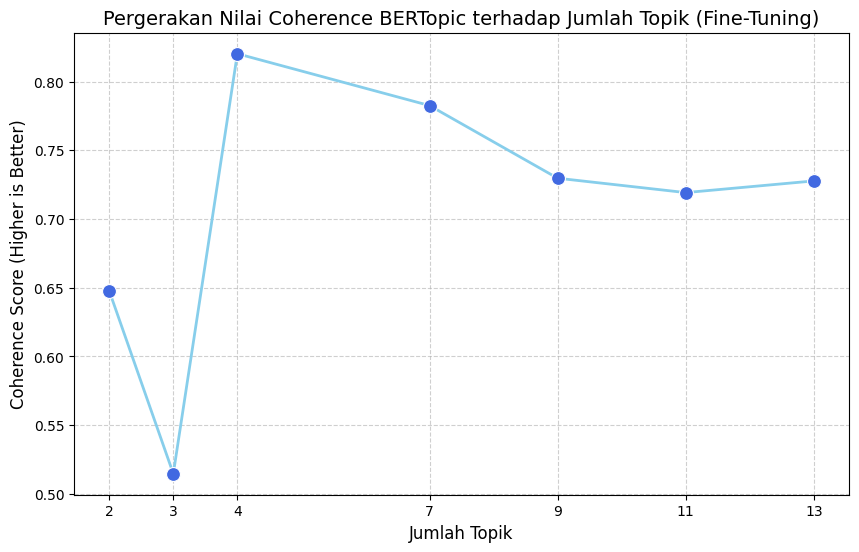

Grafik pergerakan coherence BERTopic selesai.

--- Tabel Perbandingan Performa Model (Telah Diperbarui) ---
      Model  Coherence   Perplexity
0  BERTopic   0.820338          NaN
1       LSA   0.549657          NaN
2       NMF   0.543128          NaN
3       LDA   0.473615  1185.985745
4   K-Means   0.355864          NaN


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure res_df is available from the BERTopic fine-tuning (cell 6fac3393)
if 'res_df' in locals() and not res_df.empty:
    print("Membuat grafik pergerakan nilai Coherence vs Jumlah Topik untuk BERTopic...")

    # Group by Num_Topics and take the max coherence for better visualization
    # if multiple parameter sets resulted in the same number of topics
    bertopic_coherence_trend = res_df.groupby('Num_Topics')['Coherence'].max().reset_index()

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=bertopic_coherence_trend, x='Num_Topics', y='Coherence', marker='o', color='skyblue', linewidth=2)
    sns.scatterplot(data=bertopic_coherence_trend, x='Num_Topics', y='Coherence', s=100, color='royalblue', zorder=5)

    plt.title('Pergerakan Nilai Coherence BERTopic terhadap Jumlah Topik (Fine-Tuning)', fontsize=14)
    plt.xlabel('Jumlah Topik', fontsize=12)
    plt.ylabel('Coherence Score (Higher is Better)', fontsize=12)
    plt.xticks(sorted(bertopic_coherence_trend['Num_Topics'].unique()))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    print("Grafik pergerakan coherence BERTopic selesai.")
else:
    print("Data `res_df` untuk BERTopic tidak ditemukan. Pastikan proses fine-tuning BERTopic telah dijalankan.")



# Display the final comparison table again for convenience, if it exists
if 'coherence_scores_df' in locals() and not coherence_scores_df.empty:
    print("\n--- Tabel Perbandingan Performa Model (Telah Diperbarui) ---")
    print(coherence_scores_df)
else:
    print("\nData `coherence_scores_df` tidak ditemukan.")

In [ ]:
print("Performing grid search for K-Means coherence...")

# 1. Define a list of NUM_CLUSTERS values
num_clusters_range = range(3, 11) # From 3 to 10 clusters

# 2. Initialize an empty list to store the results
kmeans_coherence_results = []

# 3. For each k in the defined range of NUM_CLUSTERS:
for k in num_clusters_range:
    print(f"  -> Testing K-Means with k={k} clusters...")
    try:
        # a. Instantiate a KMeans model with the current k
        kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels_k = kmeans_model.fit_predict(umap_embeddings_kmeans)

        # b. Assign the cluster_labels to a new 'cluster' column in the df_kmeans DataFrame
        df_kmeans['cluster_temp'] = cluster_labels_k

        # c. Group df_kmeans by the 'cluster_temp' column and aggregate 'clean_text'
        docs_per_cluster_k = df_kmeans.groupby(['cluster_temp'], as_index=False).agg({'clean_text': ' '.join})

        # d. Initialize a TfidfVectorizer and transform clean_text
        tfidf_k = TfidfVectorizer(max_df=0.9, min_df=2)
        tfidf_matrix_k = tfidf_k.fit_transform(docs_per_cluster_k['clean_text'])
        feature_names_k = tfidf_k.get_feature_names_out()

        # e. Extract the top 10 words for each cluster based on TF-IDF scores
        topic_words_k = []
        for i in range(len(docs_per_cluster_k)):
            vector = tfidf_matrix_k[i]
            sorted_indices = np.argsort(vector.toarray()).flatten()[::-1]
            top_words = [feature_names_k[idx] for idx in sorted_indices[:10]]
            topic_words_k.append(top_words)

        # f. Calculate the coherence score
        coherence_score_k = calculate_coherence_score(topic_words_k, tokens_bertopic, dictionary_bertopic)

        # g. Append results to the list
        kmeans_coherence_results.append({
            'k': k,
            'Coherence': coherence_score_k
        })
        print(f"    Coherence for k={k}: {coherence_score_k:.4f}")

    except Exception as e:
        print(f"    Error calculating coherence for k={k}: {e}")
        kmeans_coherence_results.append({
            'k': k,
            'Coherence': np.nan
        })

# 4. Convert the results list into a Pandas DataFrame
kmeans_coherence_df = pd.DataFrame(kmeans_coherence_results)

print("\nK-Means Coherence Grid Search Results:")
print(kmeans_coherence_df)

Performing grid search for K-Means coherence...
  -> Testing K-Means with k=3 clusters...
    Coherence for k=3: 0.3850
  -> Testing K-Means with k=4 clusters...
    Coherence for k=4: 0.4151
  -> Testing K-Means with k=5 clusters...
    Coherence for k=5: 0.3559
  -> Testing K-Means with k=6 clusters...
    Coherence for k=6: 0.4566
  -> Testing K-Means with k=7 clusters...
    Coherence for k=7: 0.5418
  -> Testing K-Means with k=8 clusters...
    Coherence for k=8: 0.6115
  -> Testing K-Means with k=9 clusters...
    Coherence for k=9: 0.7939
  -> Testing K-Means with k=10 clusters...
    Coherence for k=10: 0.7781

K-Means Coherence Grid Search Results:
    k  Coherence
0   3   0.384990
1   4   0.415089
2   5   0.355864
3   6   0.456558
4   7   0.541849
5   8   0.611498
6   9   0.793932
7  10   0.778144


**Reasoning**:
The K-Means grid search has been completed and the coherence scores for different numbers of clusters (k) have been calculated. To easily identify the optimal number of clusters, I will now visualize these results using a line plot.



Visualizing K-Means coherence scores...


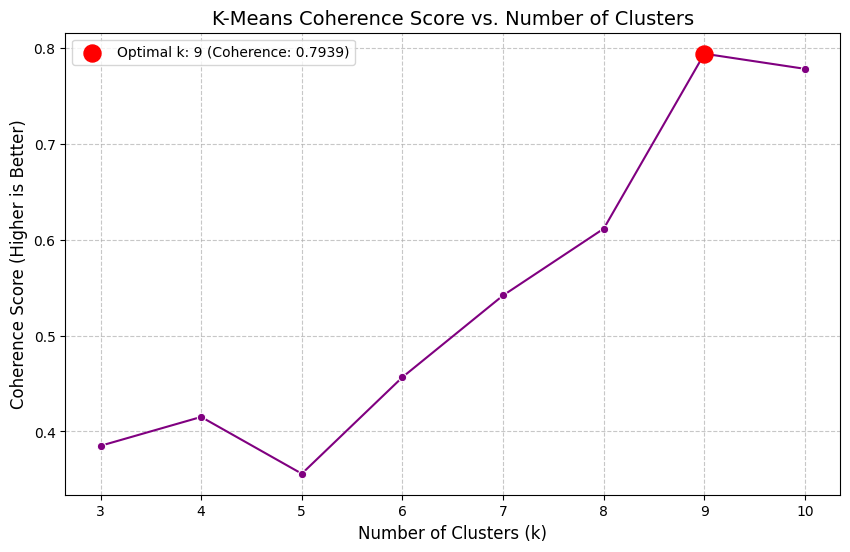

K-Means coherence visualization complete.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Visualizing K-Means coherence scores...")

plt.figure(figsize=(10, 6))
sns.lineplot(data=kmeans_coherence_df, x='k', y='Coherence', marker='o', color='purple')

# Highlight the optimal k (highest coherence)
optimal_k_row = kmeans_coherence_df.loc[kmeans_coherence_df['Coherence'].idxmax()]
plt.scatter(optimal_k_row['k'], optimal_k_row['Coherence'], color='red', s=150, zorder=5, label=f'Optimal k: {int(optimal_k_row["k"])} (Coherence: {optimal_k_row["Coherence"]:.4f})')

plt.title('K-Means Coherence Score vs. Number of Clusters', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Coherence Score (Higher is Better)', fontsize=12)
plt.xticks(kmeans_coherence_df['k'].unique())
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

print("K-Means coherence visualization complete.")

## Perform Grid Search for NMF Coherence

### Subtask:
Modify the NMF topic modeling process to iterate through a range of `n_components` (e.g., from 3 to 10), calculate the coherence score for each, and store these results (n_components and Coherence) in a DataFrame.


**Reasoning**:
I need to perform a grid search for NMF coherence by iterating through a range of `n_components` (from 3 to 10), calculate the coherence score for each, and store these results in a DataFrame, following the provided instructions.



In [ ]:
print("Performing grid search for NMF coherence...")

# 1. Define a range for the number of components
n_components_range = range(3, 11) # From 3 to 10 components

# 2. Initialize an empty list to store the coherence results
nmf_coherence_results = []

# 3. Loop through each value in the defined n_components range
for n_comp in n_components_range:
    print(f"  -> Testing NMF with n_components={n_comp}...")
    try:
        # a. Instantiate an NMF model
        nmf_model_grid = NMF(n_components=n_comp, random_state=42, init='nndsvd').fit(tfidf_classic)

        # c. Extract the top 10 words for each topic
        nmf_topic_words_grid = get_top_words_from_sklearn_model(nmf_model_grid, tfidf_vectorizer_classic.get_feature_names_out(), 10)

        # d. Calculate the coherence score
        coherence_score_nmf = calculate_coherence_score(nmf_topic_words_grid, tokens_bertopic, dictionary_bertopic)

        # e. Append results to the list
        nmf_coherence_results.append({
            'n_components': n_comp,
            'Coherence': coherence_score_nmf
        })
        print(f"    Coherence for n_components={n_comp}: {coherence_score_nmf:.4f}")

    except Exception as e:
        print(f"    Error calculating coherence for n_components={n_comp}: {e}")
        nmf_coherence_results.append({
            'n_components': n_comp,
            'Coherence': np.nan
        })

# 4. Convert the list of results into a Pandas DataFrame
nmf_coherence_df = pd.DataFrame(nmf_coherence_results)

print("\nNMF Coherence Grid Search Results:")
print(nmf_coherence_df)

Performing grid search for NMF coherence...
  -> Testing NMF with n_components=3...
    Coherence for n_components=3: 0.5825
  -> Testing NMF with n_components=4...
    Coherence for n_components=4: 0.5431
  -> Testing NMF with n_components=5...
    Coherence for n_components=5: 0.6853
  -> Testing NMF with n_components=6...
    Coherence for n_components=6: 0.6649
  -> Testing NMF with n_components=7...
    Coherence for n_components=7: 0.6953
  -> Testing NMF with n_components=8...
    Coherence for n_components=8: 0.6440
  -> Testing NMF with n_components=9...
    Coherence for n_components=9: 0.6548
  -> Testing NMF with n_components=10...
    Coherence for n_components=10: 0.7231

NMF Coherence Grid Search Results:
   n_components  Coherence
0             3   0.582459
1             4   0.543128
2             5   0.685307
3             6   0.664861
4             7   0.695310
5             8   0.644015
6             9   0.654803
7            10   0.723080


**Reasoning**:
The NMF grid search for coherence has been completed, and the results are stored in `nmf_coherence_df`. To easily identify the optimal number of components, I will now visualize these results using a line plot.



Visualizing NMF coherence scores...


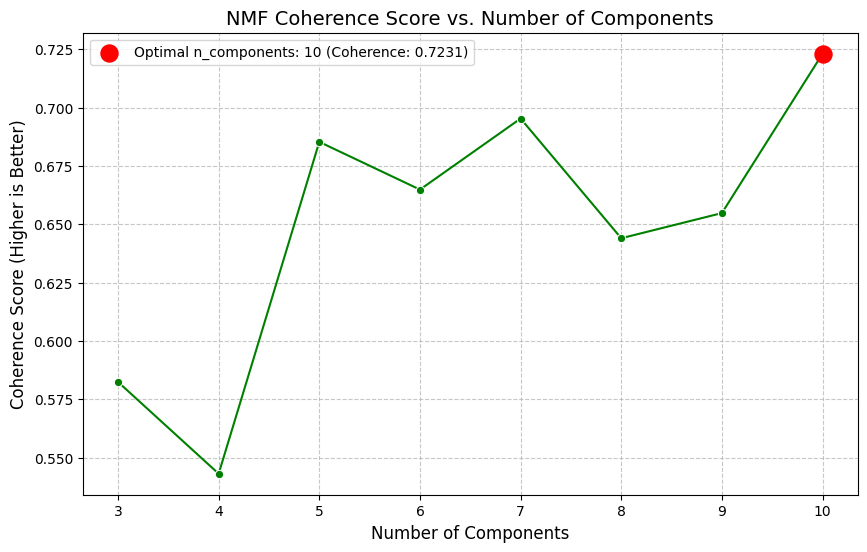

NMF coherence visualization complete.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Visualizing NMF coherence scores...")

plt.figure(figsize=(10, 6))
sns.lineplot(data=nmf_coherence_df, x='n_components', y='Coherence', marker='o', color='green')

# Highlight the optimal n_components (highest coherence)
optimal_n_comp_row = nmf_coherence_df.loc[nmf_coherence_df['Coherence'].idxmax()]
plt.scatter(optimal_n_comp_row['n_components'], optimal_n_comp_row['Coherence'], color='red', s=150, zorder=5, label=f'Optimal n_components: {int(optimal_n_comp_row["n_components"])} (Coherence: {optimal_n_comp_row["Coherence"]:.4f})')

plt.title('NMF Coherence Score vs. Number of Components', fontsize=14)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Coherence Score (Higher is Better)', fontsize=12)
plt.xticks(nmf_coherence_df['n_components'].unique())
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

print("NMF coherence visualization complete.")

## Perform Grid Search for LDA Coherence

### Subtask:
Modify the LDA topic modeling process to iterate through a range of `n_components` (e.g., from 3 to 10), calculate the coherence score for each, and store these results (n_components and Coherence) in a DataFrame.

**Reasoning**:
Now that the markdown for the LDA grid search has been added, I will provide the Python code to execute the grid search for LDA coherence. This code will iterate through a defined range of `n_components`, train an LDA model for each, calculate its coherence score, and store the results in a DataFrame as requested by the subtask.



In [ ]:
print("Performing grid search for LDA coherence...")

# 1. Define a range for the number of components
n_components_range_lda = range(3, 11) # From 3 to 10 components

# 2. Initialize an empty list to store the coherence and perplexity results
lda_results = []

# 3. Loop through each value in the defined n_components range
for n_comp in n_components_range_lda:
    print(f"  -> Testing LDA with n_components={n_comp}...")
    try:
        # a. Instantiate an LDA model
        lda_model_grid = LatentDirichletAllocation(n_components=n_comp, max_iter=20, learning_method='online', random_state=42).fit(tf_classic)

        # b. Extract the top 10 words for each topic
        lda_topic_words_grid = get_top_words_from_sklearn_model(lda_model_grid, tf_vectorizer_classic.get_feature_names_out(), 10)

        # c. Calculate the coherence score
        coherence_score_lda = calculate_coherence_score(lda_topic_words_grid, tokens_bertopic, dictionary_bertopic)

        # d. Calculate perplexity (optional but good for LDA evaluation)
        perplexity_score_lda = lda_model_grid.perplexity(tf_classic)

        # e. Append results to the list
        lda_results.append({
            'n_components': n_comp,
            'Coherence': coherence_score_lda,
            'Perplexity': perplexity_score_lda
        })
        print(f"    Coherence for n_components={n_comp}: {coherence_score_lda:.4f}, Perplexity: {perplexity_score_lda:.2f}")

    except Exception as e:
        print(f"    Error calculating coherence/perplexity for n_components={n_comp}: {e}")
        lda_results.append({
            'n_components': n_comp,
            'Coherence': np.nan,
            'Perplexity': np.nan
        })

# 4. Convert the list of results into a Pandas DataFrame
lda_coherence_df = pd.DataFrame(lda_results)

print("\nLDA Grid Search Results:")
print(lda_coherence_df)

Performing grid search for LDA coherence...
  -> Testing LDA with n_components=3...
    Coherence for n_components=3: 0.4298, Perplexity: 1346.43
  -> Testing LDA with n_components=4...
    Coherence for n_components=4: 0.4736, Perplexity: 1185.99
  -> Testing LDA with n_components=5...
    Coherence for n_components=5: 0.4185, Perplexity: 1200.31
  -> Testing LDA with n_components=6...
    Coherence for n_components=6: 0.3176, Perplexity: 1214.69
  -> Testing LDA with n_components=7...
    Coherence for n_components=7: 0.4778, Perplexity: 1246.76
  -> Testing LDA with n_components=8...
    Coherence for n_components=8: 0.4284, Perplexity: 1287.26
  -> Testing LDA with n_components=9...
    Coherence for n_components=9: 0.4599, Perplexity: 1307.92
  -> Testing LDA with n_components=10...
    Coherence for n_components=10: 0.4032, Perplexity: 1397.69

LDA Grid Search Results:
   n_components  Coherence   Perplexity
0             3   0.429829  1346.431941
1             4   0.473615  1185

**Reasoning**:
The LDA grid search has been completed and the results are stored in `lda_coherence_df`. To easily identify the optimal number of components, I will now visualize these results using a line plot.



Visualizing LDA coherence scores...


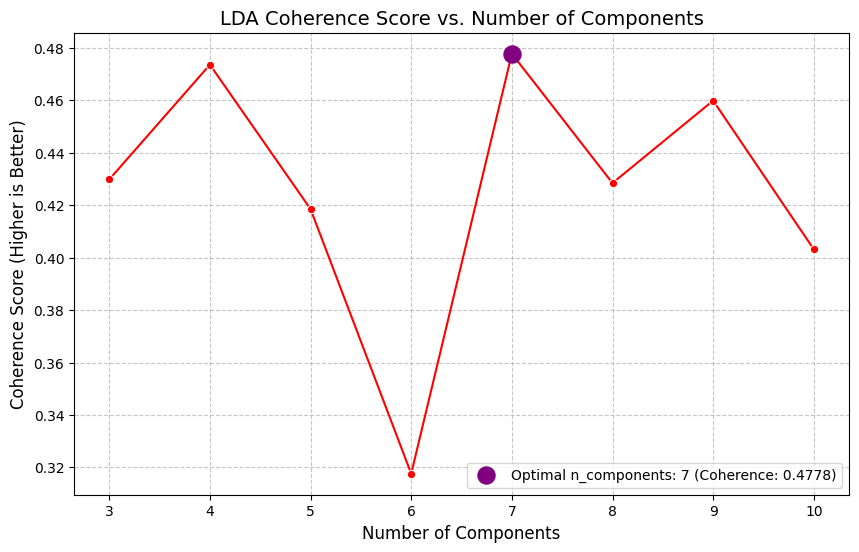

LDA coherence visualization complete.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Visualizing LDA coherence scores...")

plt.figure(figsize=(10, 6))
sns.lineplot(data=lda_coherence_df, x='n_components', y='Coherence', marker='o', color='red')

# Highlight the optimal n_components (highest coherence)
optimal_n_comp_row_lda = lda_coherence_df.loc[lda_coherence_df['Coherence'].idxmax()]
plt.scatter(optimal_n_comp_row_lda['n_components'], optimal_n_comp_row_lda['Coherence'], color='purple', s=150, zorder=5, label=f'Optimal n_components: {int(optimal_n_comp_row_lda["n_components"])} (Coherence: {optimal_n_comp_row_lda["Coherence"]:.4f})')

plt.title('LDA Coherence Score vs. Number of Components', fontsize=14)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Coherence Score (Higher is Better)', fontsize=12)
plt.xticks(lda_coherence_df['n_components'].unique())
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

print("LDA coherence visualization complete.")

In [24]:
print("Performing grid search for LSA coherence...")

# 1. Define a range for the number of components
n_components_range_lsa = range(3, 11) # From 3 to 10 components

# 2. Initialize an empty list to store the coherence results
lsa_results = []

# 3. Loop through each value in the defined n_components range
for n_comp in n_components_range_lsa:
    print(f"  -> Testing LSA with n_components={n_comp}...")
    try:
        # a. Instantiate an LSA model
        lsa_model_grid = TruncatedSVD(n_components=n_comp, random_state=42).fit(tfidf_classic)

        # b. Extract the top 10 words for each topic
        lsa_topic_words_grid = get_top_words_from_sklearn_model(lsa_model_grid, tfidf_vectorizer_classic.get_feature_names_out(), 10)

        # c. Calculate the coherence score
        coherence_score_lsa = calculate_coherence_score(lsa_topic_words_grid, tokens_bertopic, dictionary_bertopic)

        # d. Append results to the list
        lsa_results.append({
            'n_components': n_comp,
            'Coherence': coherence_score_lsa
        })
        print(f"    Coherence for n_components={n_comp}: {coherence_score_lsa:.4f}")

    except Exception as e:
        print(f"    Error calculating coherence for n_components={n_comp}: {e}")
        lsa_results.append({
            'n_components': n_comp,
            'Coherence': np.nan
        })

# 4. Convert the list of results into a Pandas DataFrame
lsa_coherence_df = pd.DataFrame(lsa_results)

print("\nLSA Coherence Grid Search Results:")
print(lsa_coherence_df)

Performing grid search for LSA coherence...
  -> Testing LSA with n_components=3...
    Coherence for n_components=3: 0.4399
  -> Testing LSA with n_components=4...
    Coherence for n_components=4: 0.5497
  -> Testing LSA with n_components=5...
    Coherence for n_components=5: 0.5646
  -> Testing LSA with n_components=6...
    Coherence for n_components=6: 0.5316
  -> Testing LSA with n_components=7...
    Coherence for n_components=7: 0.5758
  -> Testing LSA with n_components=8...
    Coherence for n_components=8: 0.5617
  -> Testing LSA with n_components=9...
    Coherence for n_components=9: 0.6189
  -> Testing LSA with n_components=10...
    Coherence for n_components=10: 0.5191

LSA Coherence Grid Search Results:
   n_components  Coherence
0             3   0.439871
1             4   0.549657
2             5   0.564627
3             6   0.531587
4             7   0.575817
5             8   0.561718
6             9   0.618947
7            10   0.519108


Visualizing LSA coherence scores...


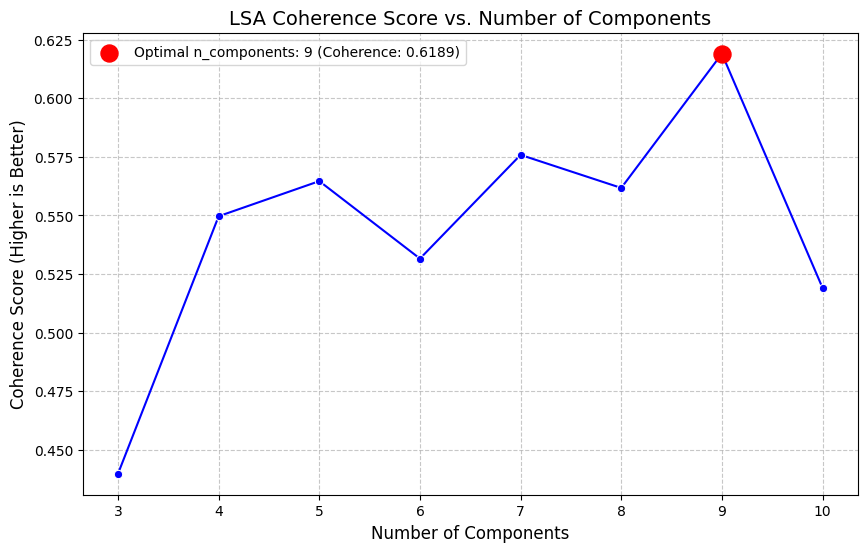

LSA coherence visualization complete.


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Visualizing LSA coherence scores...")

plt.figure(figsize=(10, 6))
sns.lineplot(data=lsa_coherence_df, x='n_components', y='Coherence', marker='o', color='blue')

# Highlight the optimal n_components (highest coherence)
optimal_n_comp_row_lsa = lsa_coherence_df.loc[lsa_coherence_df['Coherence'].idxmax()]
plt.scatter(optimal_n_comp_row_lsa['n_components'], optimal_n_comp_row_lsa['Coherence'], color='red', s=150, zorder=5, label=f'Optimal n_components: {int(optimal_n_comp_row_lsa["n_components"])} (Coherence: {optimal_n_comp_row_lsa["Coherence"]:.4f})')

plt.title('LSA Coherence Score vs. Number of Components', fontsize=14)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Coherence Score (Higher is Better)', fontsize=12)
plt.xticks(lsa_coherence_df['n_components'].unique())
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

print("LSA coherence visualization complete.")

**Reasoning**:
All individual model grid searches and visualizations are complete. The next logical step is to re-evaluate and display the overall comparison of all topic models (K-Means, BERTopic, NMF, LDA, LSA) based on their optimal coherence scores, similar to the previous comparative analysis in cell `6ff8bfd7`. This will provide a final conclusion on the best performing model after all fine-tuning and grid searches.




=== 🏆 KLASEMEN AKHIR MODEL TOPIC MODELLING (DIOPTIMASI) ===
      Model  Coherence   Perplexity  Best_k
0  BERTopic   0.820338          NaN       4
1   K-Means   0.793932          NaN       9
2       NMF   0.723080          NaN      10
3       LSA   0.618947          NaN       9
4       LDA   0.477795  1246.764561       7


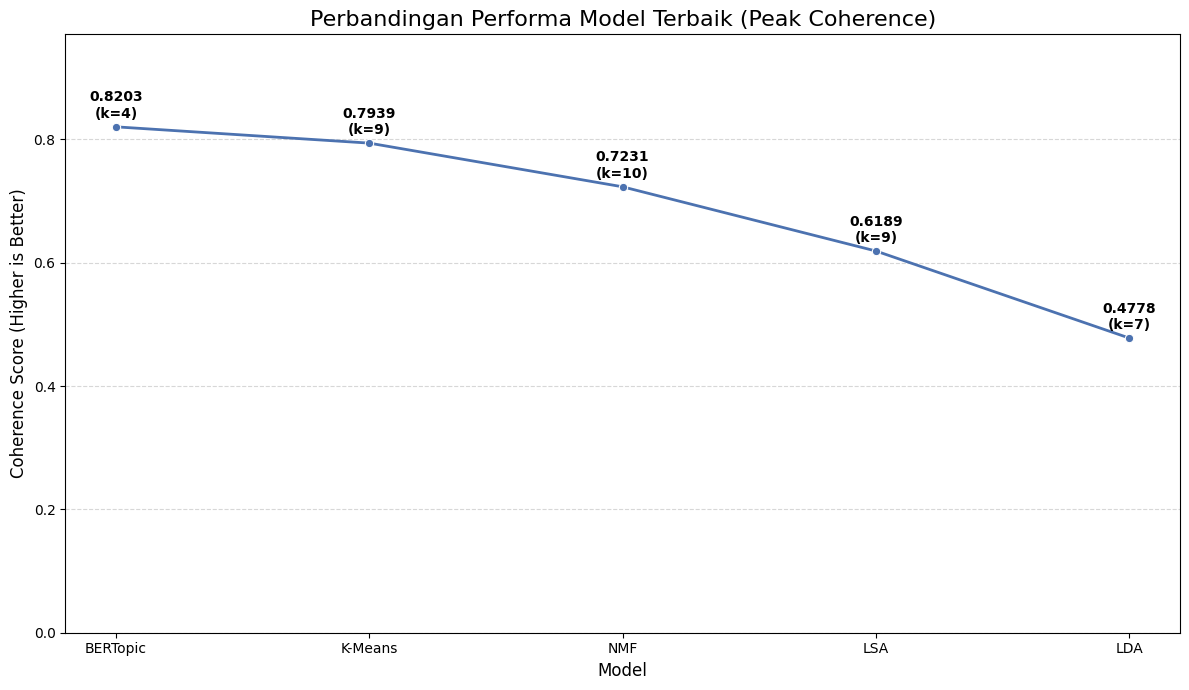


✅ KESIMPULAN MUTLAK: Model **BERTopic** adalah yang terbaik
   dengan jumlah topik optimal **k=4** dan coherence **0.8203**.


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a list to store the best results for each model
updated_model_scores = []

# K-Means
if 'kmeans_coherence_df' in locals() and not kmeans_coherence_df.empty:
    optimal_k_row_kmeans = kmeans_coherence_df.loc[kmeans_coherence_df['Coherence'].idxmax()]
    updated_model_scores.append({
        'Model': 'K-Means',
        'Coherence': optimal_k_row_kmeans['Coherence'],
        'Perplexity': np.nan,
        'Best_k': int(optimal_k_row_kmeans['k'])
    })

# BERTopic (assuming best_model from earlier BERTopic fine-tuning is available)
if 'best_model' in locals():
    updated_model_scores.append({
        'Model': 'BERTopic',
        'Coherence': best_model['Coherence'],
        'Perplexity': np.nan,
        'Best_k': int(best_model['Num_Topics'])
    })

# NMF
if 'nmf_coherence_df' in locals() and not nmf_coherence_df.empty:
    optimal_n_comp_row_nmf = nmf_coherence_df.loc[nmf_coherence_df['Coherence'].idxmax()]
    updated_model_scores.append({
        'Model': 'NMF',
        'Coherence': optimal_n_comp_row_nmf['Coherence'],
        'Perplexity': np.nan,
        'Best_k': int(optimal_n_comp_row_nmf['n_components'])
    })

# LDA
if 'lda_coherence_df' in locals() and not lda_coherence_df.empty:
    optimal_n_comp_row_lda = lda_coherence_df.loc[lda_coherence_df['Coherence'].idxmax()]
    updated_model_scores.append({
        'Model': 'LDA',
        'Coherence': optimal_n_comp_row_lda['Coherence'],
        'Perplexity': optimal_n_comp_row_lda['Perplexity'],
        'Best_k': int(optimal_n_comp_row_lda['n_components'])
    })

# LSA
if 'lsa_coherence_df' in locals() and not lsa_coherence_df.empty:
    optimal_n_comp_row_lsa = lsa_coherence_df.loc[lsa_coherence_df['Coherence'].idxmax()]
    updated_model_scores.append({
        'Model': 'LSA',
        'Coherence': optimal_n_comp_row_lsa['Coherence'],
        'Perplexity': np.nan,
        'Best_k': int(optimal_n_comp_row_lsa['n_components'])
    })

# Convert to DataFrame
df_final_comparison = pd.DataFrame(updated_model_scores)

if not df_final_comparison.empty:
    df_final_comparison = df_final_comparison.sort_values(by='Coherence', ascending=False).reset_index(drop=True)
    print("\n=== 🏆 KLASEMEN AKHIR MODEL TOPIC MODELLING (DIOPTIMASI) ===")
    print(df_final_comparison)

    plt.figure(figsize=(12, 7))
    # Use lineplot instead of barplot
    sns.lineplot(data=df_final_comparison, x='Model', y='Coherence', marker='o', color='#4c72b0', linewidth=2)

    # Annotate points with Coherence and Best_k values
    for i, row in df_final_comparison.iterrows():
        plt.text(x=i, y=row['Coherence'] + 0.01,
                 s=f"{row['Coherence']:.4f}\n(k={row['Best_k']})",
                 horizontalalignment='center', verticalalignment='bottom', fontsize=10, fontweight='bold')

    plt.title('Perbandingan Performa Model Terbaik (Peak Coherence)', fontsize=16)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Coherence Score (Higher is Better)', fontsize=12)
    plt.ylim(0, df_final_comparison['Coherence'].max() + 0.15)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    best_model_overall_final = df_final_comparison.iloc[0]
    print(f"\n✅ KESIMPULAN MUTLAK: Model **{best_model_overall_final['Model']}** adalah yang terbaik")
    print(f"   dengan jumlah topik optimal **k={best_model_overall_final['Best_k']}** dan coherence **{best_model_overall_final['Coherence']:.4f}**.")

else:
    print("\n❌ Tidak ada data untuk ditampilkan. Pastikan semua model telah dievaluasi dan skornya tercatat.")

## Visualisasi Pergerakan Coherence Score Terhadap Jumlah Topik (k) per Model

Plot di bawah ini menampilkan bagaimana nilai coherence ($C_v$) berfluktuasi untuk setiap model (K-Means, BERTopic, NMF, LDA, LSA) seiring dengan perubahan jumlah topik atau komponen (k). Ini membantu kita melihat "progress" atau tren performa setiap model dan mengidentifikasi nilai k optimal secara visual.

Menggabungkan hasil grid search dari semua model untuk visualisasi tren...


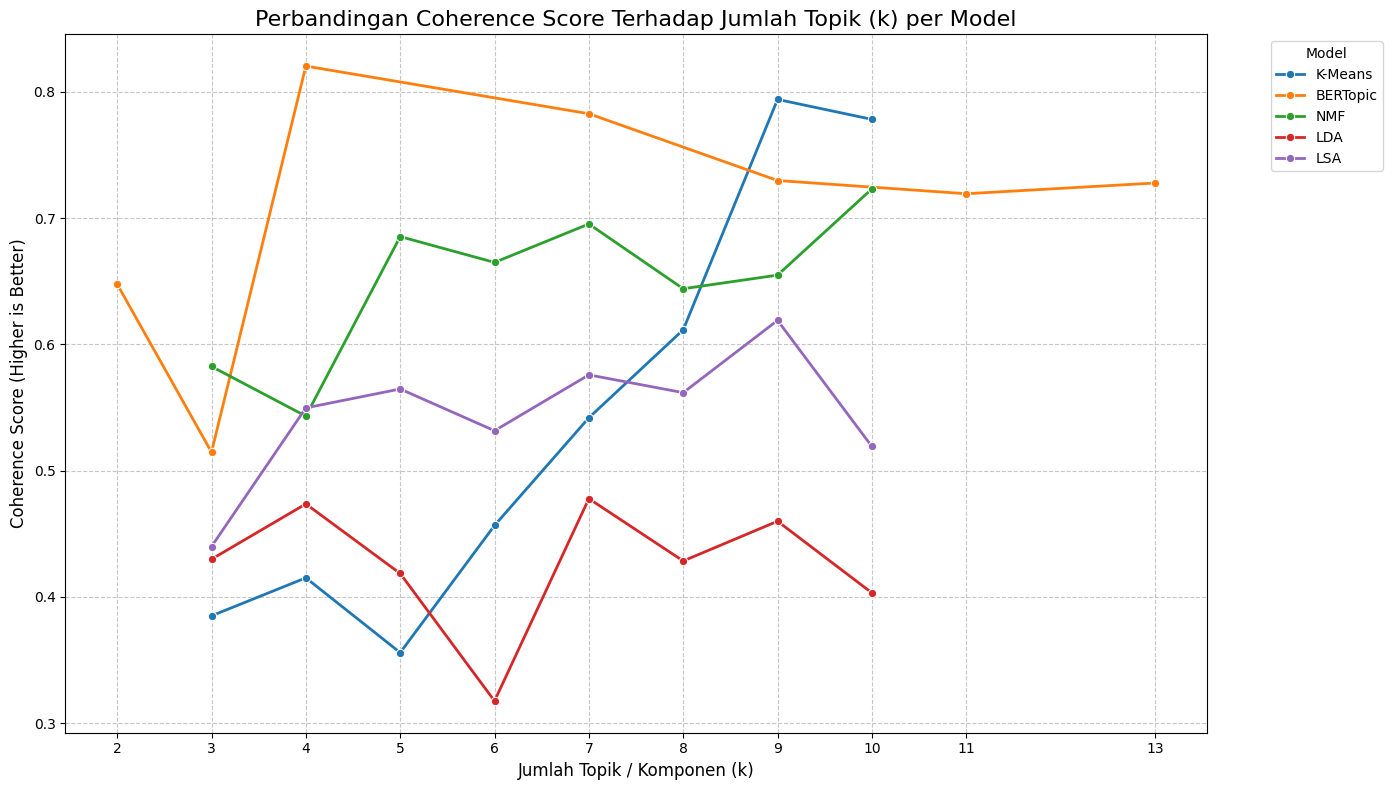

Visualisasi tren coherence per model selesai.


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Menggabungkan hasil grid search dari semua model untuk visualisasi tren...")

# Prepare data for combined plot
combined_coherence_data = []

# K-Means
if 'kmeans_coherence_df' in locals() and not kmeans_coherence_df.empty:
    for idx, row in kmeans_coherence_df.iterrows():
        combined_coherence_data.append({'Model': 'K-Means', 'k_value': row['k'], 'Coherence': row['Coherence']})

# BERTopic
# bertopic_coherence_trend already groups by Num_Topics and takes max coherence
if 'bertopic_coherence_trend' in locals() and not bertopic_coherence_trend.empty:
    for idx, row in bertopic_coherence_trend.iterrows():
        combined_coherence_data.append({'Model': 'BERTopic', 'k_value': row['Num_Topics'], 'Coherence': row['Coherence']})

# NMF
if 'nmf_coherence_df' in locals() and not nmf_coherence_df.empty:
    for idx, row in nmf_coherence_df.iterrows():
        combined_coherence_data.append({'Model': 'NMF', 'k_value': row['n_components'], 'Coherence': row['Coherence']})

# LDA
if 'lda_coherence_df' in locals() and not lda_coherence_df.empty:
    for idx, row in lda_coherence_df.iterrows():
        combined_coherence_data.append({'Model': 'LDA', 'k_value': row['n_components'], 'Coherence': row['Coherence']})

# LSA
if 'lsa_coherence_df' in locals() and not lsa_coherence_df.empty:
    for idx, row in lsa_coherence_df.iterrows():
        combined_coherence_data.append({'Model': 'LSA', 'k_value': row['n_components'], 'Coherence': row['Coherence']})

df_combined_trends = pd.DataFrame(combined_coherence_data)

if not df_combined_trends.empty:
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df_combined_trends, x='k_value', y='Coherence', hue='Model', marker='o', linewidth=2)

    plt.title('Perbandingan Coherence Score Terhadap Jumlah Topik (k) per Model', fontsize=16)
    plt.xlabel('Jumlah Topik / Komponen (k)', fontsize=12)
    plt.ylabel('Coherence Score (Higher is Better)', fontsize=12)
    plt.xticks(sorted(df_combined_trends['k_value'].unique()))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print("Visualisasi tren coherence per model selesai.")
else:
    print("Tidak ada data tren yang ditemukan untuk visualisasi.")

Generating combined bar charts for BERTopic topics...
Optimal number of BERTopic topics (k): 4


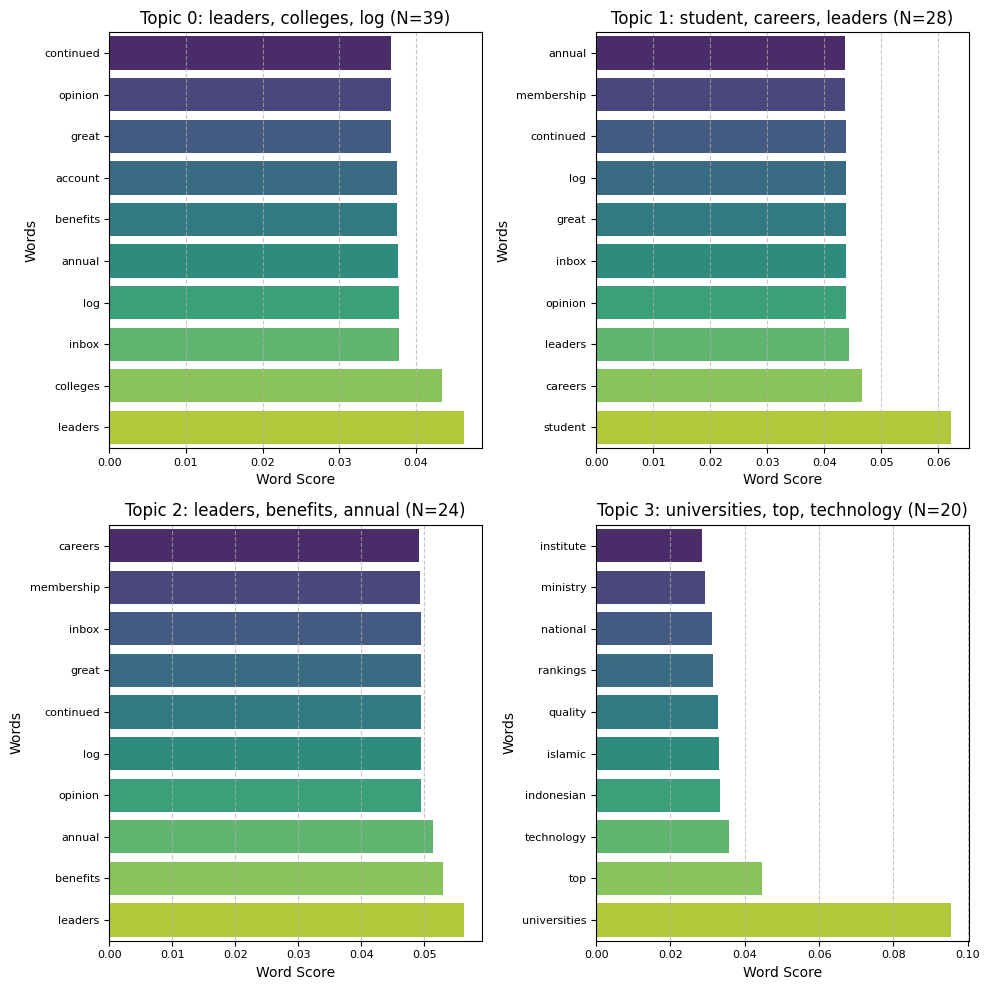

BERTopic combined bar chart generation complete.


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

print("Generating combined bar charts for BERTopic topics...")

# 1. Retrieve the optimal number of topics (k) for the BERTopic model
if 'best_model_overall_final' in locals():
    optimal_k_bertopic = int(best_model_overall_final['Best_k'])
    print(f"Optimal number of BERTopic topics (k): {optimal_k_bertopic}")
else:
    print("Error: best_model_overall_final not found. Cannot determine optimal k.")
    optimal_k_bertopic = 0 # Set to 0 to prevent further execution if optimal_k is critical

if optimal_k_bertopic > 0:
    # 2. Get topic information from the final BERTopic model
    bertopic_topic_info = final_model.get_topic_info()

    # 3. Filter out the outlier topic (Topic -1) and select the top 'optimal_k_bertopic' topics based on their size
    valid_topics = bertopic_topic_info[bertopic_topic_info['Topic'] != -1].head(optimal_k_bertopic)

    # 4. Determine the number of subplots required and create a figure
    num_subplots = len(valid_topics)
    if num_subplots == 0:
        print("No valid topics to plot. Skipping combined bar chart generation.")
    else:
        rows = math.ceil(math.sqrt(num_subplots))
        cols = math.ceil(num_subplots / rows)

        fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
        axes = axes.flatten() # Flatten the axes array for easier iteration

        # 5. Iterate through each of the selected optimal BERTopic topics and generate subplots
        for i, (index, row) in enumerate(valid_topics.iterrows()):
            ax = axes[i]

            topic_id = row['Topic']
            topic_name_full = row['Name']
            topic_count = row['Count']

            # b. Extract representative words from the full topic name for the subplot title
            representative_words = topic_name_full.split('_')[1:] # Skip topic ID part
            representative_words_str = ', '.join(representative_words[:3]) # Limit to 3 words for conciseness

            # c. Use final_model.get_topic(topic_id) to get the top words and their scores
            topic_words_with_scores = final_model.get_topic(topic_id)

            if not topic_words_with_scores:
                print(f"  -> No words found for topic {topic_id}. Skipping subplot.")
                ax.set_visible(False) # Hide empty subplot
                continue

            # d. Create a DataFrame with the words and scores, sorting it for proper horizontal bar chart display
            df_topic_words = pd.DataFrame(topic_words_with_scores[:10], columns=['Word', 'Score']) # Take top 10 words
            df_topic_words = df_topic_words.sort_values(by='Score', ascending=True) # Sort for horizontal bar chart display

            # e. Generate a horizontal bar chart for the current topic as a subplot
            sns.barplot(x='Score', y='Word', data=df_topic_words, palette='viridis', ax=ax)
            ax.set_title(f'Topic {topic_id}: {representative_words_str} (N={topic_count})', fontsize=12)
            ax.set_xlabel('Word Score', fontsize=10)
            ax.set_ylabel('Words', fontsize=10)
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.grid(axis='x', linestyle='--', alpha=0.7)

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        # 6. Adjust the layout to prevent overlapping titles and labels
        plt.tight_layout()
        # 7. Display the combined figure
        plt.show()

    print("BERTopic combined bar chart generation complete.")
else:
    print("BERTopic combined bar chart generation skipped due to missing optimal k or no valid topics.")

Generating combined bar charts for K-Means topics...
Optimal number of K-Means clusters (k): 9


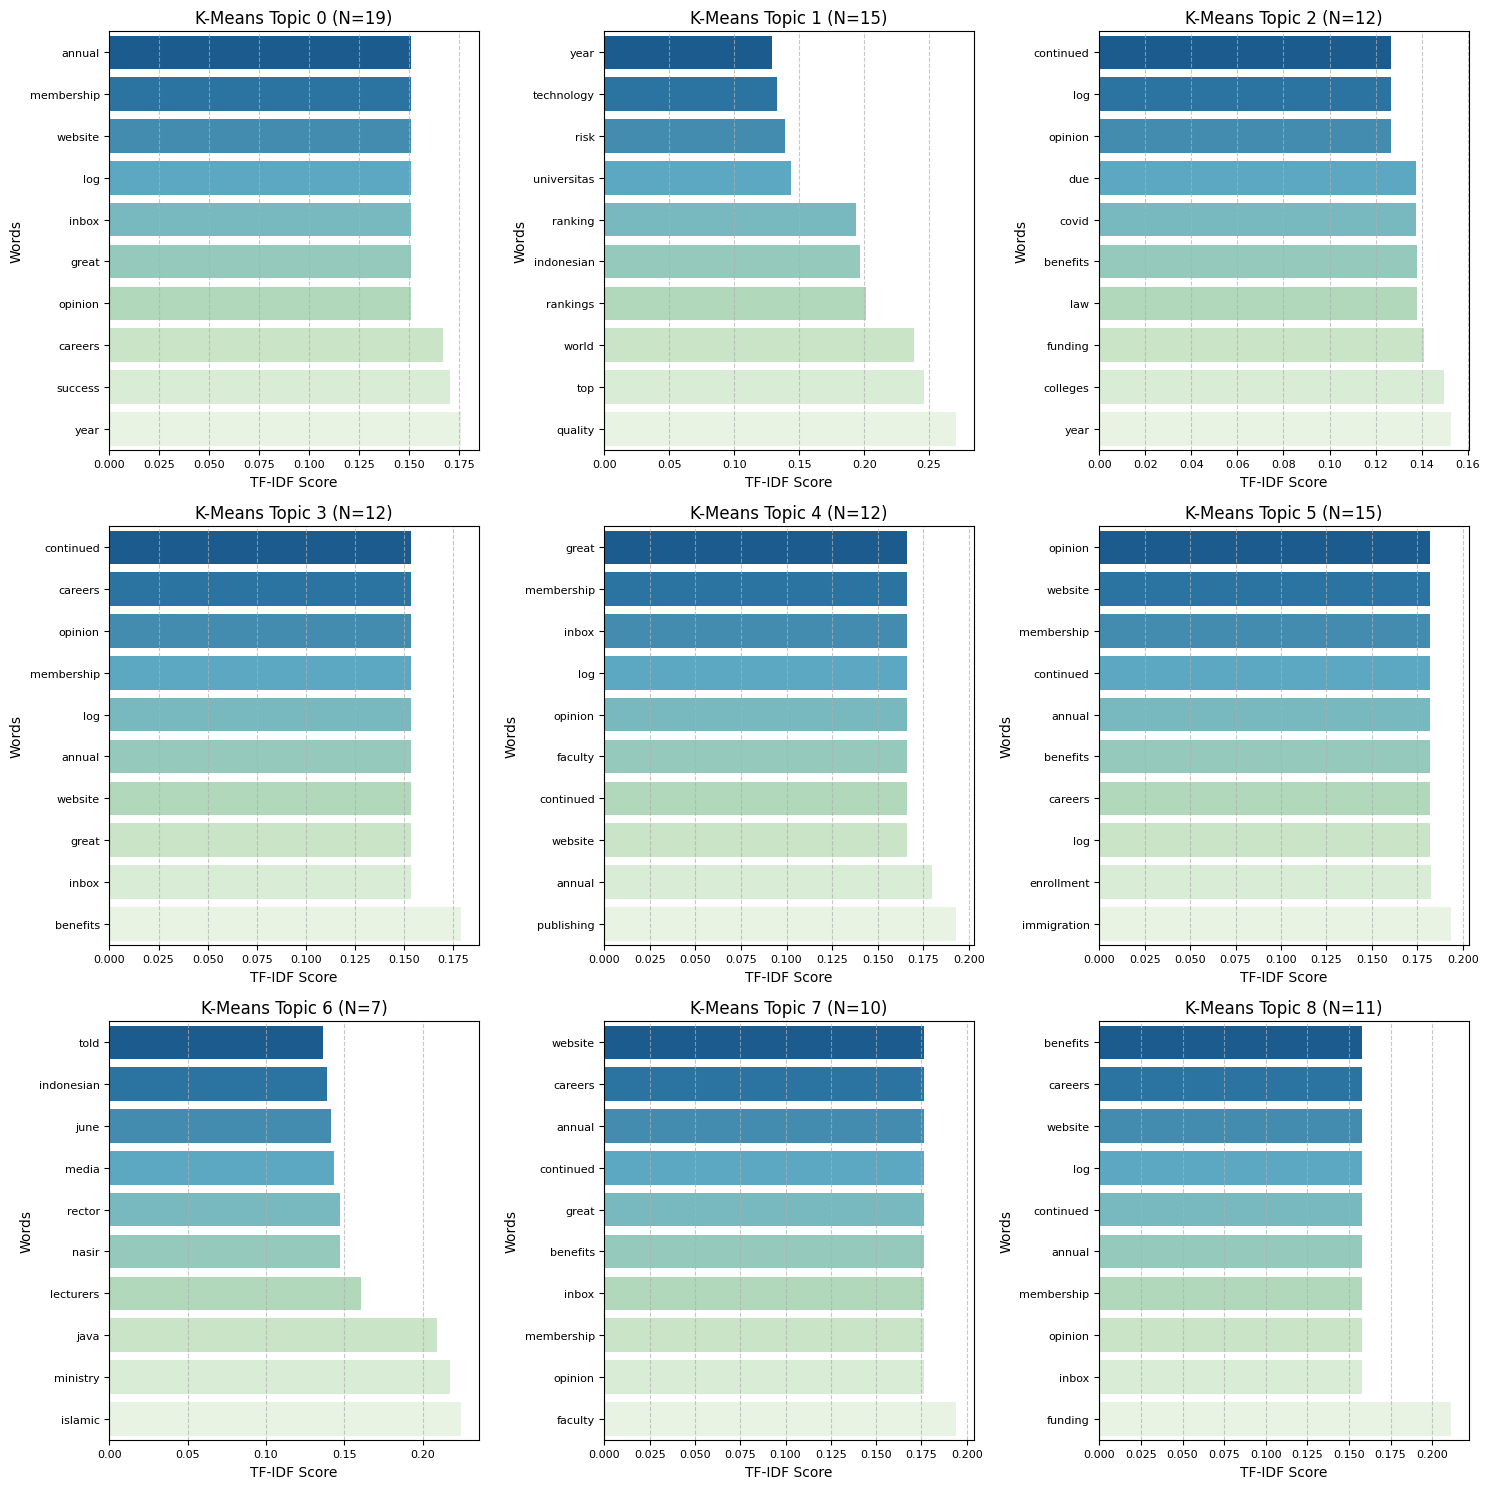

K-Means combined bar chart generation complete.


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import numpy as np

print("Generating combined bar charts for K-Means topics...")

# 1. Retrieve the optimal number of clusters (k) for K-Means
# Assuming kmeans_coherence_df is available from previous execution
if 'kmeans_coherence_df' in locals() and not kmeans_coherence_df.empty:
    optimal_k_row_kmeans = kmeans_coherence_df.loc[kmeans_coherence_df['Coherence'].idxmax()]
    optimal_k_kmeans = int(optimal_k_row_kmeans['k'])
    print(f"Optimal number of K-Means clusters (k): {optimal_k_kmeans}")
else:
    print("Error: kmeans_coherence_df not found. Cannot determine optimal k.")
    optimal_k_kmeans = 0 # Set to 0 to prevent further execution if optimal_k is critical

if optimal_k_kmeans > 0:
    # 2. Re-run K-Means clustering with this optimal k
    # umap_embeddings_kmeans and df_kmeans are assumed to be available from previous cells
    kmeans_model_optimal = KMeans(n_clusters=optimal_k_kmeans, random_state=42, n_init=10)
    cluster_labels_optimal = kmeans_model_optimal.fit_predict(umap_embeddings_kmeans)
    df_kmeans['cluster_optimal'] = cluster_labels_optimal

    # 3. Group df_kmeans by these cluster_labels and aggregate clean_text
    docs_per_cluster_optimal = df_kmeans.groupby(['cluster_optimal'], as_index=False).agg({'clean_text': ' '.join})

    # 4. Apply TF-IDF vectorization
    tfidf_optimal = TfidfVectorizer(max_df=0.9, min_df=2)
    tfidf_matrix_optimal = tfidf_optimal.fit_transform(docs_per_cluster_optimal['clean_text'])
    feature_names_optimal = tfidf_optimal.get_feature_names_out()

    # 5. Determine the number of subplots required and create a figure
    num_subplots = len(docs_per_cluster_optimal)
    if num_subplots == 0:
        print("No valid clusters to plot. Skipping combined bar chart generation.")
    else:
        rows = math.ceil(math.sqrt(num_subplots))
        cols = math.ceil(num_subplots / rows)

        fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
        axes = axes.flatten() # Flatten the axes array for easier iteration

        # 6. For each cluster (topic), extract the top 10 words and create a subplot
        for i, topic_id in enumerate(sorted(docs_per_cluster_optimal['cluster_optimal'].unique())):
            ax = axes[i]

            # Get the vector for the current topic
            vector = tfidf_matrix_optimal[topic_id]
            # Get sorted indices to find top words
            sorted_indices = np.argsort(vector.toarray()).flatten()[::-1]

            # Extract top 10 words and their scores
            top_words_with_scores = []
            for idx in sorted_indices[:10]: # Get top 10 words
                word = feature_names_optimal[idx]
                score = vector.toarray()[0, idx]
                top_words_with_scores.append({'Word': word, 'Score': score})

            if not top_words_with_scores:
                print(f"  -> No words found for K-Means topic {topic_id}. Skipping subplot.")
                ax.set_visible(False) # Hide empty subplot
                continue

            # Create DataFrame for plotting
            df_topic_words = pd.DataFrame(top_words_with_scores)
            df_topic_words = df_topic_words.sort_values(by='Score', ascending=True) # Sort for horizontal bar chart display

            # Generate horizontal bar chart for the current topic as a subplot
            sns.barplot(x='Score', y='Word', data=df_topic_words, palette='GnBu_r', ax=ax)
            ax.set_title(f'K-Means Topic {topic_id} (N={len(df_kmeans[df_kmeans["cluster_optimal"] == topic_id])})', fontsize=12)
            ax.set_xlabel('TF-IDF Score', fontsize=10)
            ax.set_ylabel('Words', fontsize=10)
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.grid(axis='x', linestyle='--', alpha=0.7)

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        # 7. Adjust the layout to prevent overlapping titles and labels
        plt.tight_layout()
        # 8. Display the combined figure
        plt.show()

    print("K-Means combined bar chart generation complete.")
else:
    print("K-Means combined bar chart generation skipped due to missing optimal k or no valid clusters.")

Generating combined bar charts for NMF topics...
Optimal number of NMF components: 10


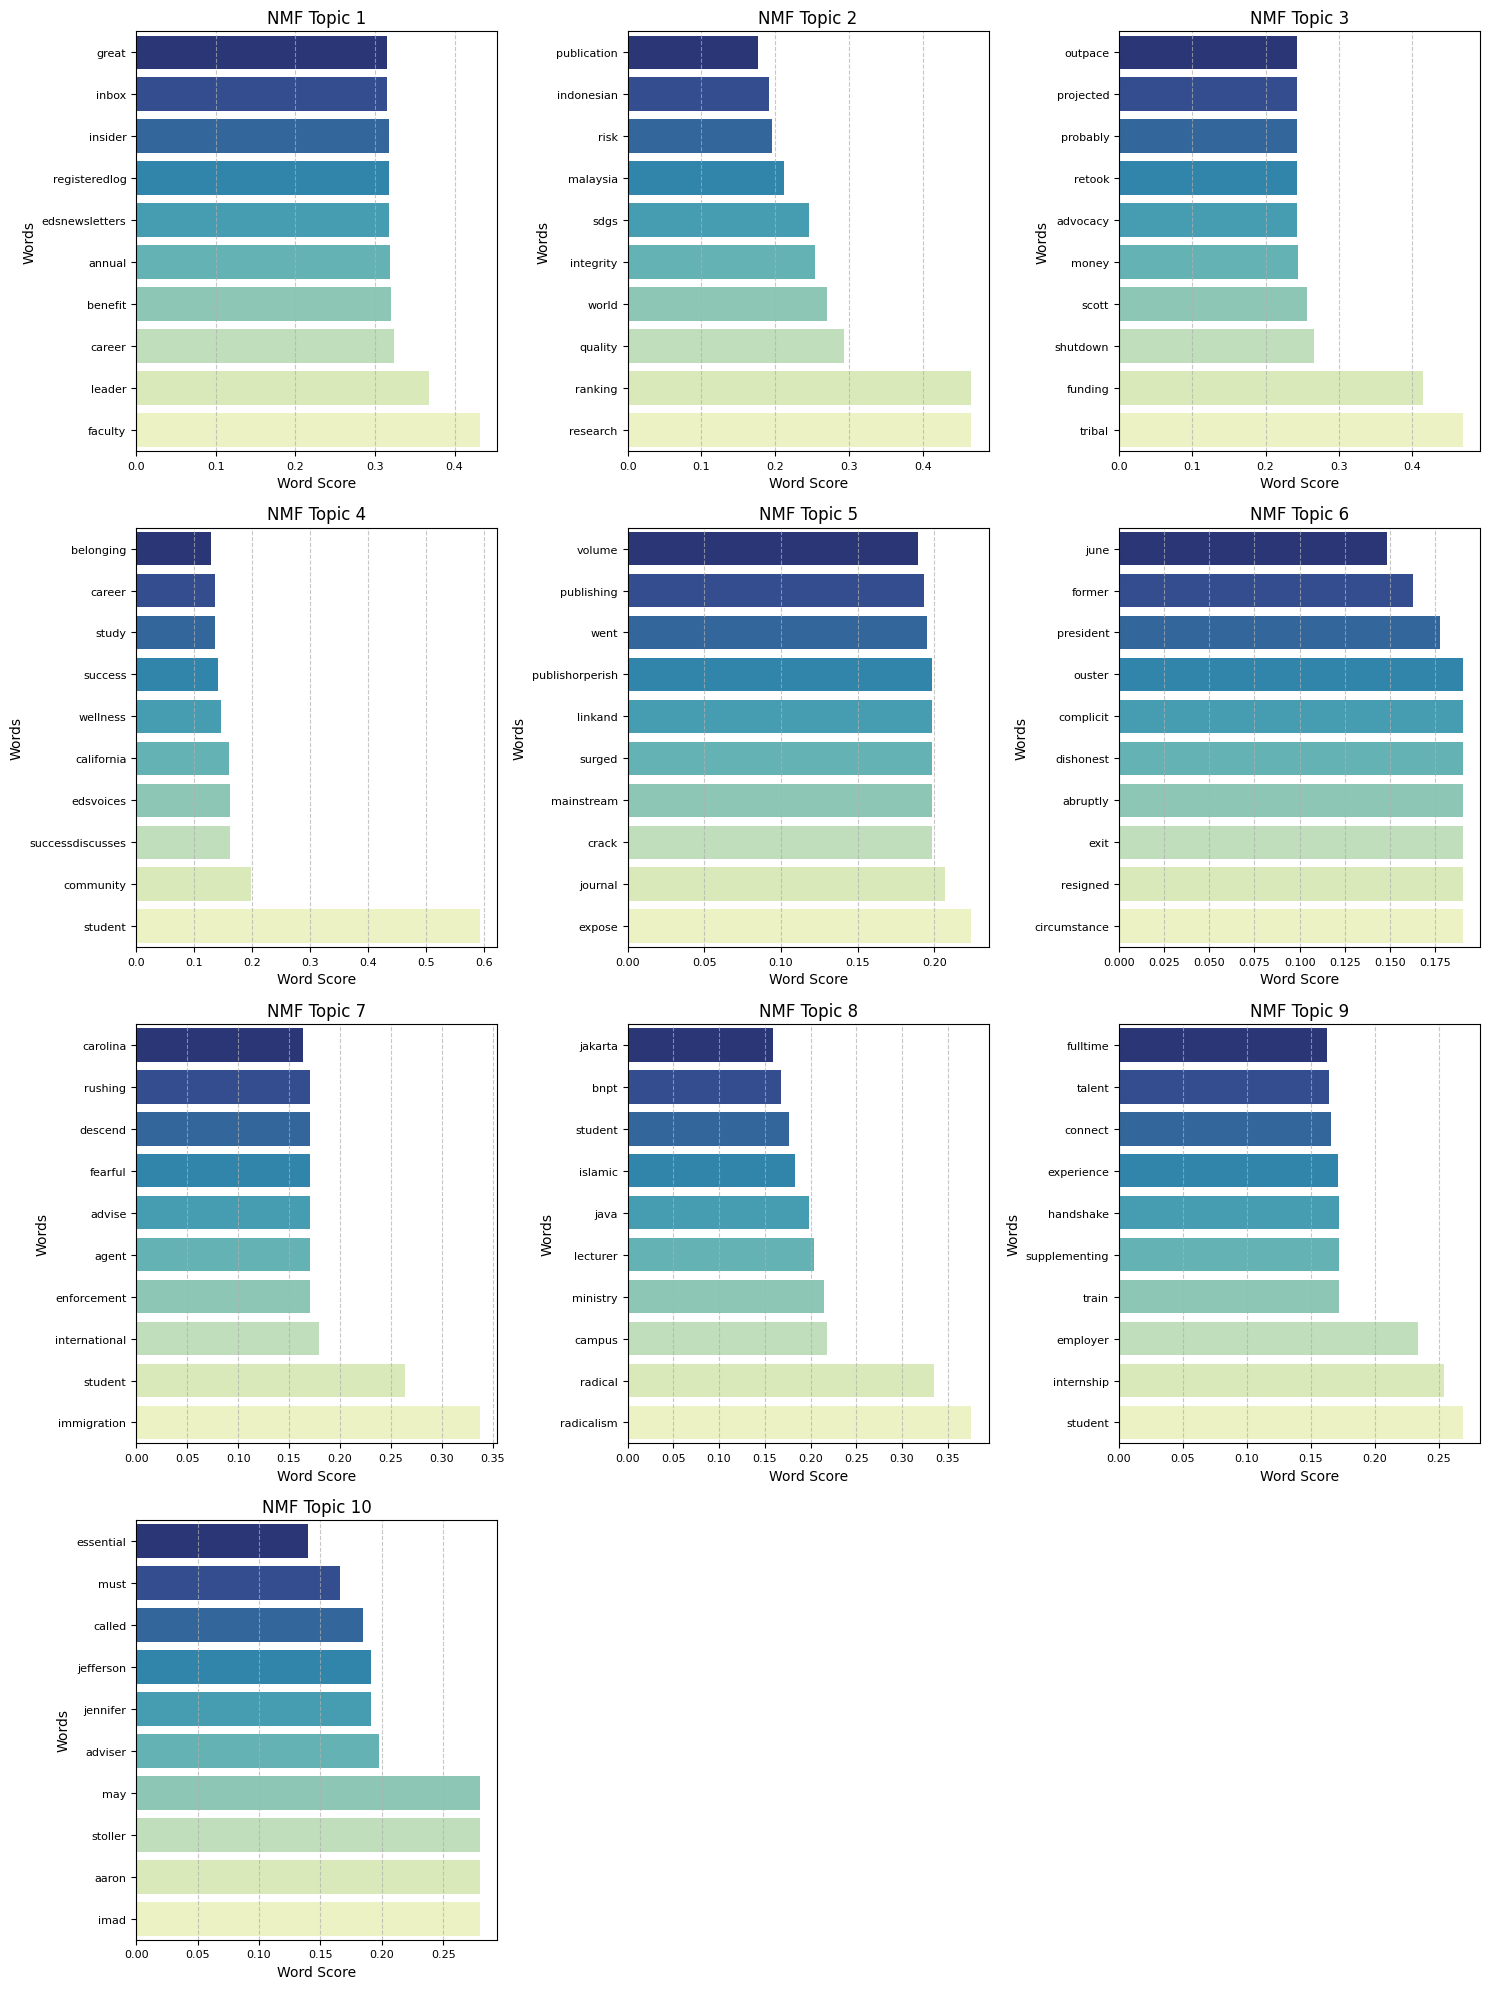

NMF combined bar chart generation complete.


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

print("Generating combined bar charts for NMF topics...")

# 1. Retrieve the optimal number of components (n_components) for NMF
# Assuming nmf_coherence_df is available from previous execution
if 'nmf_coherence_df' in locals() and not nmf_coherence_df.empty:
    optimal_n_comp_row_nmf = nmf_coherence_df.loc[nmf_coherence_df['Coherence'].idxmax()]
    optimal_n_components_nmf = int(optimal_n_comp_row_nmf['n_components'])
    print(f"Optimal number of NMF components: {optimal_n_components_nmf}")
else:
    print("Error: nmf_coherence_df not found. Cannot determine optimal n_components.")
    optimal_n_components_nmf = 0 # Set to 0 to prevent further execution if optimal_n_components is critical

if optimal_n_components_nmf > 0:
    # 2. Re-run NMF with this optimal n_components
    # tfidf_vectorizer_classic and df_classic are assumed to be available from previous cells
    tfidf_vectorizer_nmf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=list(stop_words_list_classic))
    tfidf_nmf = tfidf_vectorizer_nmf.fit_transform(df_classic['clean_classic'])
    nmf_model_optimal = NMF(n_components=optimal_n_components_nmf, random_state=42, init='nndsvd').fit(tfidf_nmf)

    # 3. Determine the number of subplots required and create a figure
    num_subplots = optimal_n_components_nmf
    if num_subplots == 0:
        print("No valid topics to plot. Skipping combined bar chart generation.")
    else:
        rows = math.ceil(math.sqrt(num_subplots))
        cols = math.ceil(num_subplots / rows)

        fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
        axes = axes.flatten() # Flatten the axes array for easier iteration

        # 4. Extract top words for each topic and create a subplot
        feature_names_nmf = tfidf_vectorizer_nmf.get_feature_names_out()
        for i, topic_idx in enumerate(range(optimal_n_components_nmf)):
            ax = axes[i]

            # Get top 10 words and their scores for the current NMF topic
            topic = nmf_model_optimal.components_[topic_idx]
            top_features_idx = topic.argsort()[:-11:-1] # Get top 10 words
            topic_words = [{'Word': feature_names_nmf[k], 'Score': topic[k]} for k in top_features_idx]

            if not topic_words:
                print(f"  -> No words found for NMF topic {topic_idx}. Skipping subplot.")
                ax.set_visible(False) # Hide empty subplot
                continue

            # Create DataFrame for plotting
            df_topic_words = pd.DataFrame(topic_words)
            df_topic_words = df_topic_words.sort_values(by='Score', ascending=True) # Sort for horizontal bar chart display

            # Generate horizontal bar chart for the current topic as a subplot
            sns.barplot(x='Score', y='Word', data=df_topic_words, palette='YlGnBu_r', ax=ax)
            ax.set_title(f'NMF Topic {topic_idx + 1}', fontsize=12)
            ax.set_xlabel('Word Score', fontsize=10)
            ax.set_ylabel('Words', fontsize=10)
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.grid(axis='x', linestyle='--', alpha=0.7)

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        # 5. Adjust the layout to prevent overlapping titles and labels
        plt.tight_layout()
        # 6. Display the combined figure
        plt.show()

    print("NMF combined bar chart generation complete.")
else:
    print("NMF combined bar chart generation skipped due to missing optimal n_components.")

Generating combined bar charts for LDA topics...
Optimal number of LDA components: 7


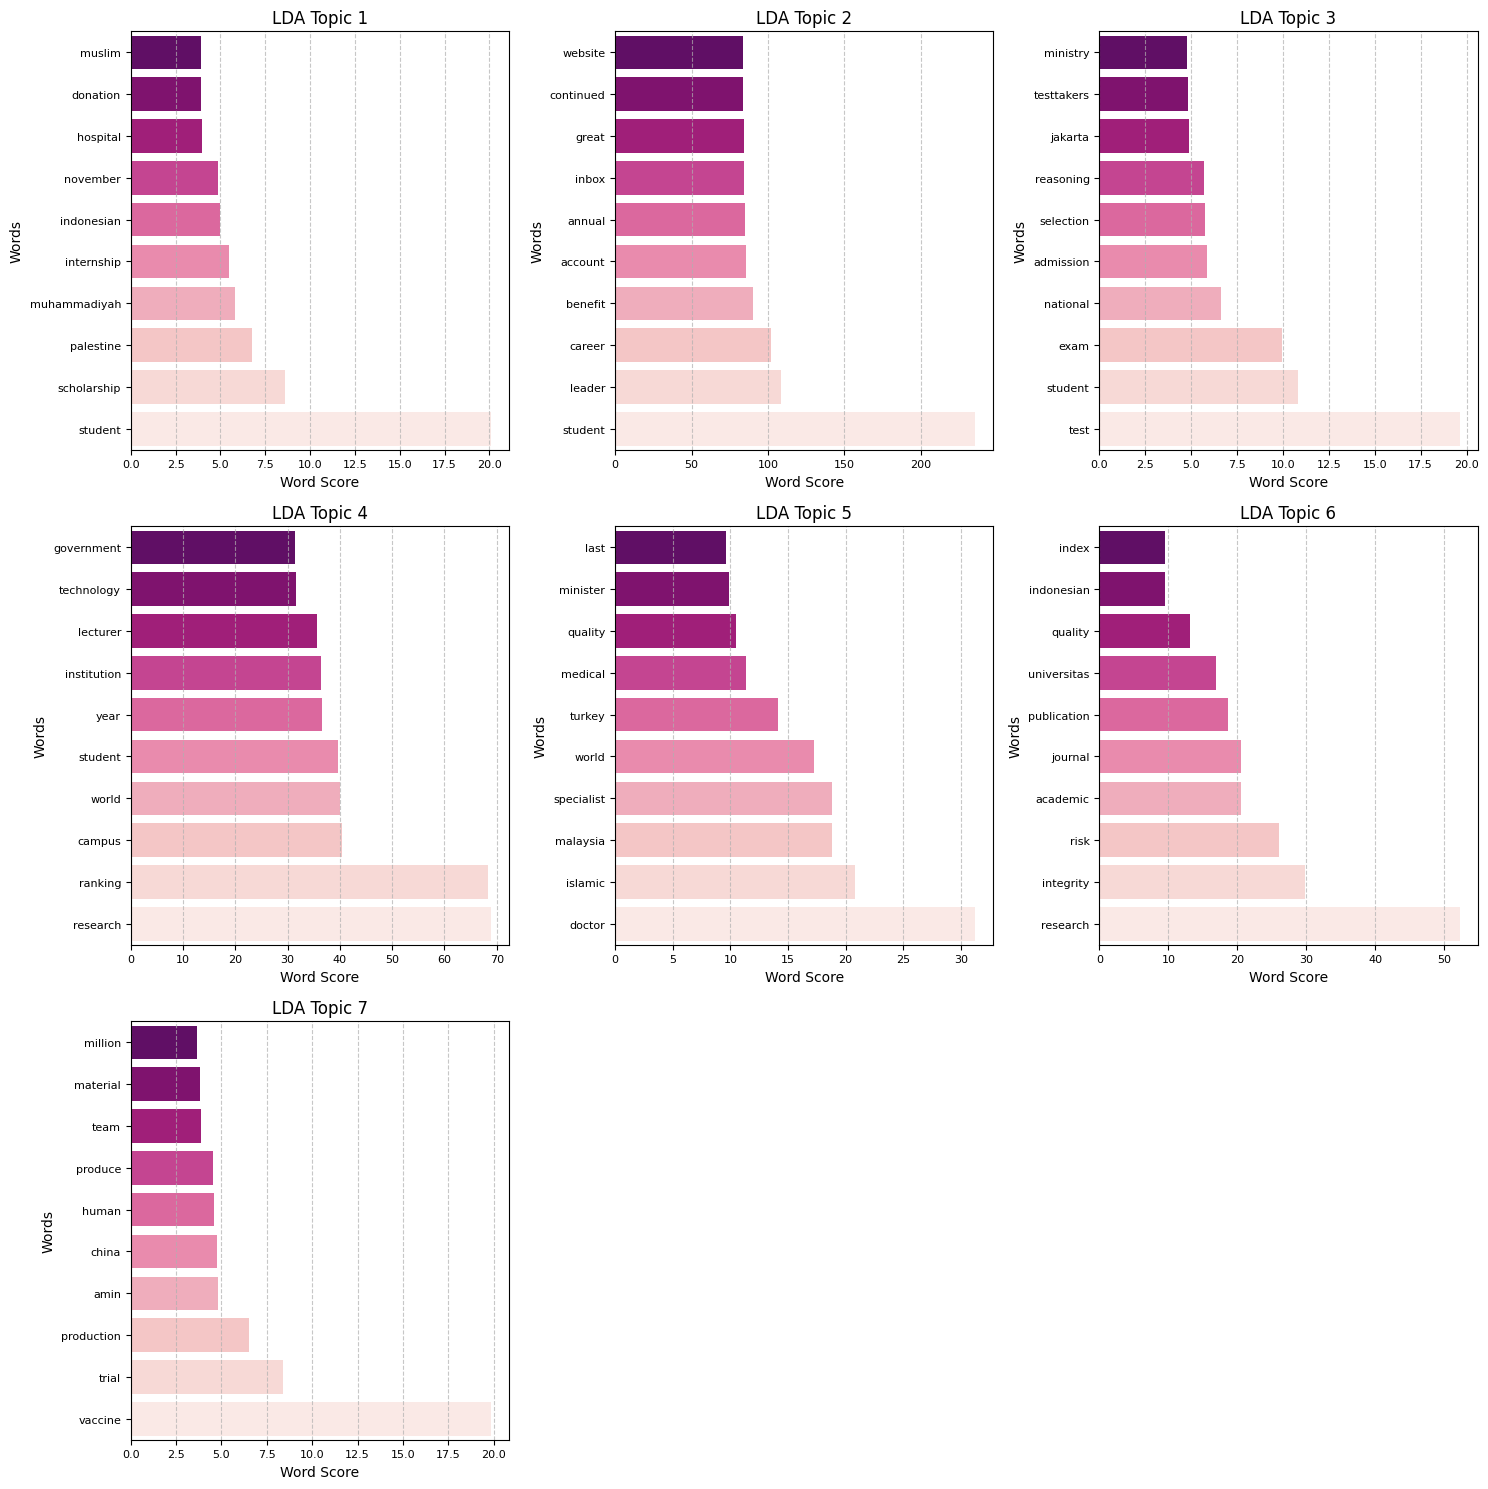

LDA combined bar chart generation complete.


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

print("Generating combined bar charts for LDA topics...")

# 1. Retrieve the optimal number of components (n_components) for LDA
# Assuming lda_coherence_df is available from previous execution
if 'lda_coherence_df' in locals() and not lda_coherence_df.empty:
    optimal_n_comp_row_lda = lda_coherence_df.loc[lda_coherence_df['Coherence'].idxmax()]
    optimal_n_components_lda = int(optimal_n_comp_row_lda['n_components'])
    print(f"Optimal number of LDA components: {optimal_n_components_lda}")
else:
    print("Error: lda_coherence_df not found. Cannot determine optimal n_components.")
    optimal_n_components_lda = 0 # Set to 0 to prevent further execution if optimal_n_components is critical

if optimal_n_components_lda > 0:
    # 2. Re-run LDA with this optimal n_components
    # tf_vectorizer_classic and df_classic are assumed to be available from previous cells
    tf_vectorizer_lda = CountVectorizer(max_df=0.95, min_df=2, stop_words=list(stop_words_list_classic))
    tf_lda = tf_vectorizer_lda.fit_transform(df_classic['clean_classic'])
    lda_model_optimal = LatentDirichletAllocation(n_components=optimal_n_components_lda, max_iter=20, learning_method='online', random_state=42).fit(tf_lda)

    # 3. Determine the number of subplots required and create a figure
    num_subplots = optimal_n_components_lda
    if num_subplots == 0:
        print("No valid topics to plot. Skipping combined bar chart generation.")
    else:
        rows = math.ceil(math.sqrt(num_subplots))
        cols = math.ceil(num_subplots / rows)

        fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
        axes = axes.flatten() # Flatten the axes array for easier iteration

        # 4. Extract top words for each topic and create a subplot
        feature_names_lda = tf_vectorizer_lda.get_feature_names_out()
        for i, topic_idx in enumerate(range(optimal_n_components_lda)):
            ax = axes[i]

            # Get top 10 words and their scores for the current LDA topic
            topic = lda_model_optimal.components_[topic_idx]
            top_features_idx = topic.argsort()[:-11:-1] # Get top 10 words
            topic_words = [{'Word': feature_names_lda[k], 'Score': topic[k]} for k in top_features_idx]

            if not topic_words:
                print(f"  -> No words found for LDA topic {topic_idx}. Skipping subplot.")
                ax.set_visible(False) # Hide empty subplot
                continue

            # Create DataFrame for plotting
            df_topic_words = pd.DataFrame(topic_words)
            df_topic_words = df_topic_words.sort_values(by='Score', ascending=True) # Sort for horizontal bar chart display

            # Generate horizontal bar chart for the current topic as a subplot
            sns.barplot(x='Score', y='Word', data=df_topic_words, palette='RdPu_r', ax=ax)
            ax.set_title(f'LDA Topic {topic_idx + 1}', fontsize=12)
            ax.set_xlabel('Word Score', fontsize=10)
            ax.set_ylabel('Words', fontsize=10)
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.grid(axis='x', linestyle='--', alpha=0.7)

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        # 5. Adjust the layout to prevent overlapping titles and labels
        plt.tight_layout()
        # 6. Display the combined figure
        plt.show()

    print("LDA combined bar chart generation complete.")
else:
    print("LDA combined bar chart generation skipped due to missing optimal n_components.")

Generating combined bar charts for LSA topics...
Optimal number of LSA components: 9


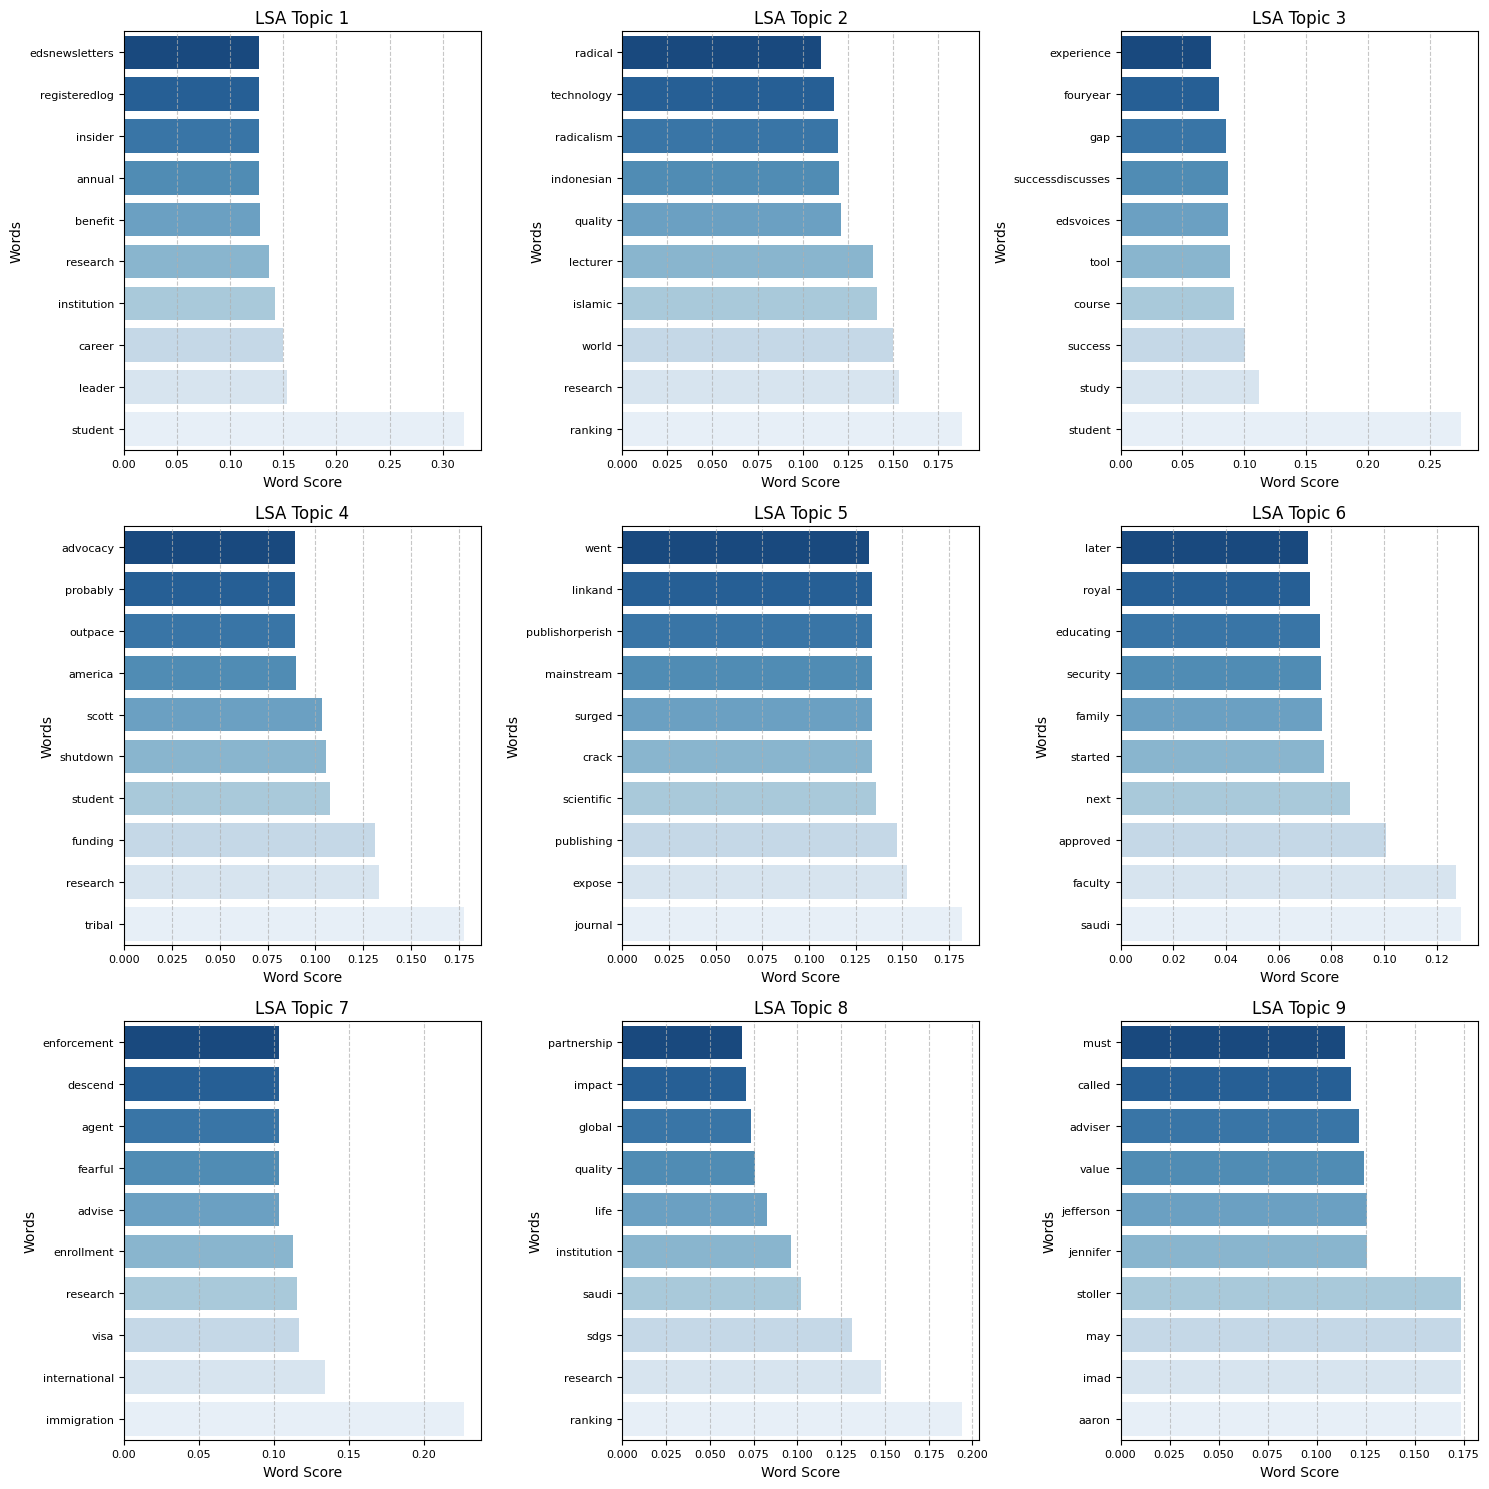

LSA combined bar chart generation complete.


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

print("Generating combined bar charts for LSA topics...")

# 1. Retrieve the optimal number of components (n_components) for LSA
# Assuming lsa_coherence_df is available from previous execution
if 'lsa_coherence_df' in locals() and not lsa_coherence_df.empty:
    optimal_n_comp_row_lsa = lsa_coherence_df.loc[lsa_coherence_df['Coherence'].idxmax()]
    optimal_n_components_lsa = int(optimal_n_comp_row_lsa['n_components'])
    print(f"Optimal number of LSA components: {optimal_n_components_lsa}")
else:
    print("Error: lsa_coherence_df not found. Cannot determine optimal n_components.")
    optimal_n_components_lsa = 0 # Set to 0 to prevent further execution if optimal_n_components is critical

if optimal_n_components_lsa > 0:
    # 2. Re-run LSA with this optimal n_components
    # tfidf_vectorizer_classic and df_classic are assumed to be available from previous cells
    lsa_model_optimal = TruncatedSVD(n_components=optimal_n_components_lsa, random_state=42).fit(tfidf_classic)

    # 3. Determine the number of subplots required and create a figure
    num_subplots = optimal_n_components_lsa
    if num_subplots == 0:
        print("No valid topics to plot. Skipping combined bar chart generation.")
    else:
        rows = math.ceil(math.sqrt(num_subplots))
        cols = math.ceil(num_subplots / rows)

        fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
        axes = axes.flatten() # Flatten the axes array for easier iteration

        # 4. Extract top words for each topic and create a subplot
        feature_names_lsa = tfidf_vectorizer_classic.get_feature_names_out()
        for i, topic_idx in enumerate(range(optimal_n_components_lsa)):
            ax = axes[i]

            # Get top 10 words and their scores for the current LSA topic
            topic = lsa_model_optimal.components_[topic_idx]
            top_features_idx = topic.argsort()[:-11:-1] # Get top 10 words
            topic_words = [{'Word': feature_names_lsa[k], 'Score': topic[k]} for k in top_features_idx]

            if not topic_words:
                print(f"  -> No words found for LSA topic {topic_idx}. Skipping subplot.")
                ax.set_visible(False) # Hide empty subplot
                continue

            # Create DataFrame for plotting
            df_topic_words = pd.DataFrame(topic_words)
            df_topic_words = df_topic_words.sort_values(by='Score', ascending=True) # Sort for horizontal bar chart display

            # Generate horizontal bar chart for the current topic as a subplot
            sns.barplot(x='Score', y='Word', data=df_topic_words, palette='Blues_r', ax=ax)
            ax.set_title(f'LSA Topic {topic_idx + 1}', fontsize=12)
            ax.set_xlabel('Word Score', fontsize=10)
            ax.set_ylabel('Words', fontsize=10)
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.grid(axis='x', linestyle='--', alpha=0.7)

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        # 5. Adjust the layout to prevent overlapping titles and labels
        plt.tight_layout()
        # 6. Display the combined figure
        plt.show()

    print("LSA combined bar chart generation complete.")
else:
    print("LSA combined bar chart generation skipped due to missing optimal n_components.")